Capstone Project II: Kiva.org loan delays
    
Data source - https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding

Goal of the project: predict reasons for delays in loan approvals by kiva org

In [2]:
%matplotlib inline
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore, normaltest, shapiro, norm, t
from collections import Counter
sns.set()
from scipy import stats
import scipy
import statsmodels.api as sm

## Data Cleaning and Exploration

In [5]:
# Load data
data = pd.read_csv("all_kiva_loans_copy.csv")

In [6]:
data.head()

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disburse_time,raised_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
0,657307,125.0,125.0,funded,General Store,Retail,to buy additional inventories for her sari-sa...,PH,Philippines,Ozamiz - Ozamiz City,...,PHP,126.0,2014-01-15 02:23:45.000 +0000,2014-02-14 03:30:06.000 +0000,2013-12-22 08:00:00.000 +0000,2014-01-15 04:48:22.000 +0000,7.0,3,female,irregular
1,657259,400.0,400.0,funded,Used Clothing,Clothing,"To buy American clothing such as blouses, shir...",HN,Honduras,"La Lopez, Choloma",...,HNL,201.0,2014-01-14 20:23:20.000 +0000,2014-03-26 22:25:07.000 +0000,2013-12-20 08:00:00.000 +0000,2014-02-25 06:42:06.000 +0000,8.0,11,female,monthly
2,658010,400.0,400.0,funded,General Store,Retail,"to buy stock of rice, sugar and flour",PK,Pakistan,Lala Musa,...,PKR,245.0,2014-01-16 11:32:58.000 +0000,2014-02-15 21:10:05.000 +0000,2014-01-09 08:00:00.000 +0000,2014-01-24 23:06:18.000 +0000,14.0,16,female,monthly
3,659347,625.0,625.0,funded,Farming,Agriculture,"to buy cucumber and tomato seeds, as well as f...",KG,Kyrgyzstan,"Aravan village, Osh region",...,KGS,171.0,2014-01-20 09:59:48.000 +0000,2014-02-21 03:10:02.000 +0000,2014-01-17 08:00:00.000 +0000,2014-01-22 05:29:28.000 +0000,14.0,21,female,monthly
4,656933,425.0,425.0,funded,Farming,Agriculture,to buy organic fertilizer and agrochemical pr...,PH,Philippines,"Baleleng, Sto. Thomas, Isabela",...,PHP,123.0,2014-01-14 05:46:21.000 +0000,2014-02-13 06:10:02.000 +0000,2013-12-17 08:00:00.000 +0000,2014-01-14 17:29:27.000 +0000,7.0,15,male,bullet


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1419607 entries, 0 to 1419606
Data columns (total 21 columns):
loan_id                    1419607 non-null int64
funded_amount              1419607 non-null float64
loan_amount                1419607 non-null float64
status                     1419607 non-null object
activity_name              1419607 non-null object
sector_name                1419607 non-null object
loan_use                   1376334 non-null object
country_code               1419598 non-null object
country_name               1419607 non-null object
town_name                  1257849 non-null object
currency_policy            1419607 non-null object
currency                   1419607 non-null object
partner_id                 1402817 non-null float64
posted_time                1419607 non-null object
planned_expiration_time    1047773 non-null object
disburse_time              1416794 non-null object
raised_time                1355325 non-null object
lender_term       

As we can see main time related features has wrong datatypes. We need to change the datatypes

In [24]:
# change raised_time label to funded_time to match with other feature such as funded_amount
data.rename(columns={'raised_time':'funded_time'}, inplace=True)

In [26]:
# change the dtype of the main variables of study to datetime64[ns]
data['posted_time'] = pd.to_datetime(data['posted_time'], errors='coerce')
data['planned_expiration_time'] = pd.to_datetime(data['planned_expiration_time'], errors='coerce')
data['disburse_time'] = pd.to_datetime(data['disburse_time'], errors='coerce')
data['funded_time'] = pd.to_datetime(data['funded_time'], errors='coerce')

In [27]:
# As seen above, there are no missing values and the filled ones seem to be ok
data[['posted_time', 'disburse_time', 'funded_time']].describe()

,posted_time,disburse_time,funded_time
count,1419607,1416794,1355325
unique,1415162,75668,1137793
top,2006-04-16 07:10:50+00:00,2017-02-01 08:00:00+00:00,2005-03-31 06:27:55+00:00
freq,207,2800,203
first,2006-04-16 07:10:50+00:00,2005-04-14 05:27:55+00:00,2005-03-31 06:27:55+00:00
last,2018-01-11 07:11:23+00:00,2018-03-19 07:00:00+00:00,2018-01-11 03:11:44+00:00


## Posted Time

In [28]:
# checking frequency
data['posted_time'].value_counts().head()

2006-04-16 07:10:50+00:00    207
2015-05-27 08:05:17+00:00      3
2008-02-12 22:15:45+00:00      3
2015-03-12 08:01:30+00:00      3
2016-04-26 08:08:20+00:00      3
Name: posted_time, dtype: int64

'posted_time' column is clean

## Raised time

In [29]:
# checking for missing values
data['funded_time'].isna().value_counts()

False    1355325
True       64282
Name: funded_time, dtype: int64

Though some null-values might correspond to loans which were indeed funded, there is not a way to know how to fill those values, and let us not consider the following ones for analysis, so that there is no ambiguity.

In [30]:
# rows where there is a missing value in funded_time but (loan_amount - funded_amount) <= 0

missing_ft = data[data['funded_time'].isna()] 
missing_ft[(missing_ft['loan_amount'] - missing_ft['funded_amount']) <= 0]

# Note: we are only considering where funding amount is larger than loan amount
# The remaining missing values will be kept due to several reasons. Not every loan is funded, or when there is a filled value in funded_amount, because the loan may not be completely funded yet, that is, the funded_amount is smaller than the loan_amount.

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disburse_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
142677,849172,700.0,700.0,expired,Cereals,Food,to buy maize to sell.,UG,Uganda,Hoima,...,UGX,163.0,2015-03-02 13:07:56+00:00,2015-04-06 12:20:02+00:00,2015-02-18 08:00:00+00:00,NaT,12.0,25,male,monthly
508508,985199,3400.0,3000.0,expired,Farm Supplies,Agriculture,"to pay for wires for the grape orchard, cover ...",AM,Armenia,"Hoktember village, Armavir region",...,USD,169.0,2015-11-25 10:53:00+00:00,2015-12-28 19:20:08+00:00,2015-10-29 07:00:00+00:00,NaT,38.0,84,male,monthly
628009,114629,125.0,125.0,refunded,Retail,Retail,NaN,PH,Philippines,NaN,...,PHP,128.0,2009-06-11 01:27:29+00:00,NaT,2009-05-29 07:00:00+00:00,NaT,12.0,5,NaN,irregular
657411,38915,1475.0,1475.0,expired,Food Market,Food,To expand fresh food business,UG,Uganda,Nansana,...,UGX,65.0,2008-02-28 07:10:56+00:00,NaT,2008-07-22 07:00:00+00:00,NaT,NaN,24,"female, female, female, female, female",irregular
809473,924149,425.0,400.0,expired,General Store,Retail,"to buy beverages, rice, laundry detergent, sug...",MZ,Mozambique,"Boane, Maputo",...,MZN,23.0,2015-07-28 07:14:04+00:00,2015-09-09 18:30:02+00:00,2015-07-22 07:00:00+00:00,NaT,17.0,11,male,monthly
861839,147,1000.0,1000.0,refunded,Farming,Agriculture,NaN,BG,Bulgaria,NaN,...,USD,3.0,2006-04-16 07:10:50+00:00,NaT,2006-03-15 05:00:00+00:00,NaT,6.0,16,NaN,bullet
1368801,408534,1275.0,1275.0,expired,Agriculture,Agriculture,To buy the inventory for his fruit and vegetab...,AZ,Azerbaijan,NaN,...,AZN,207.0,2012-03-24 13:05:34+00:00,2012-05-02 15:00:03+00:00,2012-03-07 08:00:00+00:00,NaT,20.0,44,female,monthly


Regarding the filled values, there are 2 columns with which we can compare to check if there are discrepancies:

funded_amount and status
'raised_time' vs 'funded_amount'

In [31]:
# Comparing with the funded_amount column, if there are no discrepancies
data[(data['funded_time'].notnull()) & (data['funded_amount'] > 0)].count()[['funded_time', 'funded_amount']]

funded_time      1355325
funded_amount    1355325
dtype: int64

In [33]:
# However, when looking at the difference between loan_amount and funded_amount, we notice inconsistency in the data
ft_notnull = data[data['funded_time'].notnull()] 
ft_notnull[(ft_notnull['loan_amount'] - ft_notnull['funded_amount']) > 0] 

# Note: the funded_time is only filled when the loan is 100% funded by lenders

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disburse_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
60715,57210,925.0,950.0,funded,Clothing,Clothing,Increase business capital,RW,Rwanda,Gasabo/Buliza/Rwanda,...,RWF,117.0,2008-07-17 15:59:58+00:00,NaT,2008-08-05 07:00:00+00:00,2008-07-22 18:26:42+00:00,14.0,35,female,monthly
233811,44276,475.0,500.0,funded,Food Production/Sales,Food,NaN,KE,Kenya,NaN,...,KES,36.0,2008-04-08 13:26:42+00:00,NaT,2008-05-03 05:39:35+00:00,2008-04-19 05:39:35+00:00,14.0,14,NaN,monthly
518536,48958,25.0,950.0,refunded,Food Production/Sales,Food,NaN,SN,Senegal,NaN,...,XOF,105.0,2008-05-15 16:09:47+00:00,NaT,2008-05-31 07:00:00+00:00,2008-05-17 22:33:56+00:00,8.0,1,NaN,monthly
577064,745,125.0,1000.0,refunded,Sewing,Services,NaN,KH,Cambodia,NaN,...,USD,9.0,2006-08-18 09:12:23+00:00,NaT,2006-09-11 02:34:47+00:00,2006-08-28 02:34:47+00:00,21.0,4,NaN,monthly


So let us not consider these rows also, so that we have clean data

In [35]:
# Comparing with the status column:

# datetime and status columns described
data[['posted_time', 'funded_time', 'status']].describe()

,posted_time,funded_time,status
count,1419607,1355325,1419607
unique,1415162,1137793,4
top,2006-04-16 07:10:50+00:00,2005-03-31 06:27:55+00:00,funded
freq,207,203,1350340
first,2006-04-16 07:10:50+00:00,2005-03-31 06:27:55+00:00,NaN
last,2018-01-11 07:11:23+00:00,2018-01-11 03:11:44+00:00,NaN


In [37]:
# status column variables
data['status'].value_counts()

funded         1350340
expired          59081
refunded          6578
fundRaising       3608
Name: status, dtype: int64

In [40]:
# comparing funded_time non nulls with 'status':funded
data[(data['status'] == 'funded') & (data['funded_time'].notnull())].count()[['funded_time', 'status']]

funded_time    1350340
status         1350340
dtype: int64

Whenever the loan is described as 'funded', a corresponding value appears in the 'funded_time' column

In [41]:
# comparing funded_time non nulls with 'status' = refunded
data[(data['status'] == 'refunded') & (data['funded_time'].notnull())].count()[['funded_time', 'status']]

funded_time    4983
status         4983
dtype: int64

Whenever the loan is described as 'refunded', a corresponding value appears in the 'funded_time' column.

We can see that the sum of the rows where the status is indicated as 'funded' with the ones where it is indicated as 'refunded' has less 2 values than the total number of 'funded_time' values

In [42]:
# funded_time non nulls with 'status':funded
ft_f = data[(data['status'] == 'funded') & (data['funded_time'].notnull())].count().status 

# funded_time non nulls with 'status' = refunded
ft_ref = data[(data['status'] == 'refunded') & (data['funded_time'].notnull())].count().status

# funded_time total non nulls
ft_tot = data['funded_time'].count()

ft_tot - (ft_f + ft_ref)

2

In [43]:
# comparing funded_time non nulls with 'status' = expired
data[(data['status'] == 'expired') & (data['funded_time'].notnull())]

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disburse_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
926652,601656,925.0,925.0,expired,Home Products Sales,Retail,to purchase clothing and household items for r...,GE,Georgia,Vani,...,GEL,181.0,2013-08-29 13:43:33+00:00,2013-10-03 15:10:02+00:00,2013-07-31 07:00:00+00:00,2013-10-03 15:16:01+00:00,15.0,29,female,monthly
1144537,149173,4600.0,4600.0,expired,Retail,Retail,Increase working capital,BO,Bolivia,NaN,...,BOB,73.0,2009-10-30 20:19:53+00:00,NaT,2009-10-29 07:00:00+00:00,2009-12-01 07:12:13+00:00,8.0,125,"female, female, female, female, female, female...",monthly


We have two loans requests which supposedly expired but, at the same time, two values for the 'funded_time' column are filled.

In this case, however, the remaining variables seem to indicate that the loan was indeed funded, so I will consider them for analysis. For example, in the first case, what probably classified the status as expired was the fact that the funded_time was slightly after (6 minutes) the planned_expiration_time.

These two values are the ones which were missing from the previous analysis.

Let us will change the status in these two cases to 'funded'.

In [45]:
to_replace = (data['status'] == 'expired') & (data['funded_time'].notnull())

data.loc[to_replace, 'status'] = 'funded'

In [46]:
# comparing funded_time non nulls with 'status' = fundRaising
data[(data['status'] == 'fundRaising') & (data['funded_time'].notnull())].count()[['funded_time', 'status']]

funded_time    0
status         0
dtype: int64

In [47]:
# rows where there is a missing value in funded_time but (loan_amount - funded_amount) <= 0
missing_ft = data[data['funded_time'].isna()] 
not_rows = missing_ft[(missing_ft['loan_amount'] - missing_ft['funded_amount']) <= 0]

# and

# rows where funded_time is not null but (loan_amount - funded_amount) > 0
ft_notnull = data[data['funded_time'].notnull()] 
not_rows_2 = ft_notnull[(ft_notnull['loan_amount'] - ft_notnull['funded_amount']) > 0]

Let us create new dataframe with new data

In [49]:
# removing the rows
df = data.drop(not_rows.index)
df = df.drop(not_rows_2.index)

In [51]:
# new shape
df.shape

(1419596, 21)

### 'disbursed_time'

In [53]:
# filled and missing values
df['disburse_time'].isna().value_counts()

False    1416783
True        2813
Name: disburse_time, dtype: int64

Regarding the missing values:
It may be the case that there was a posted_time or funded_time but the disbursal has not occurred yet. I will leave those values for further analysis since they could represent loans which were not delivered or just expected situations.

Regarding the filled values
As said in the introduction, the timing of the disbursal can vary. For most Field Partner loans, the money is pre-disbursed, so the borrower can access the funds right away. Hence, it is not strange if the disbursed_time is made even before the posted_time. For direct loans, the money is disbursed only after the loan has been fully crowdfunded on the Kiva website.

It can then naturally occur after or before the posted_time or the funded_time.

### 'posted_time' vs 'funded_time

As we have seen, the chronological order between the 'posted_time' and the 'disbursal_time' does not matter, as well as between the 'disbursal_time' and the 'funded_time'.

What could biase the data is when the 'funded_time' appears before the 'posted_time'.

In [56]:
# cases
pt_ft_cases = df[df['funded_time'] < df['posted_time']]

# brief look
pt_ft_cases[['funded_time', 'posted_time']].head()

,funded_time,posted_time
85222,2005-03-31 06:27:55+00:00,2006-04-16 07:10:50+00:00
85369,2005-03-31 06:27:55+00:00,2006-04-16 07:10:50+00:00
89113,2005-03-31 06:27:55+00:00,2006-04-16 07:10:50+00:00
99222,2005-03-31 06:27:55+00:00,2006-04-16 07:10:50+00:00
106582,2005-03-31 06:27:55+00:00,2006-04-16 07:10:50+00:00


In [57]:
# number of cases where funded_time is made before the posted_time 
pt_ft_cases.count()[['funded_time', 'posted_time']]

funded_time    203
posted_time    203
dtype: int64

In [58]:
# unique dates where funded_time is made before the posted_time
set(pt_ft_cases.posted_time)

{Timestamp('2006-04-16 07:10:50+0000', tz='UTC')}

In [59]:
# unique time differences
set(pt_ft_cases['posted_time'] - pt_ft_cases['funded_time'])

{Timedelta('381 days 00:42:55')}

In [62]:
# first posted_time date
min(df['posted_time'])

Timestamp('2006-04-16 07:10:50+0000', tz='UTC')

As we can see, these cases correspond to the loans which were first posted by Kiva. Let us will not consider them for analysis.

In [64]:
# removing the rows
df = df.drop(pt_ft_cases.index)

# new shape
df.shape

(1419393, 21)

### Other variables    

The funded_amount column appears to be compatible with the num_lenders_total column.

In [65]:
# funded_amount  
print("There are", df['funded_amount'][df['funded_amount'] == 0].count(), "zeros in the column 'funded_amount'")

# num_lenders_total
print("There are", df['num_lenders_total'][df['num_lenders_total'] == 0].count(), "zeros in the column 'num_lenders_total'")

There are 2568 zeros in the column 'funded_amount'
There are 2568 zeros in the column 'num_lenders_total'


If the funded_amount is greater or equal to the loan_amount, then the status should not appear as expired.

In [66]:
df[(df['funded_amount'] >= df['loan_amount']) & (df['status'] == 'expired')]

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disburse_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval


### Checking for misspellings    

'activity_name'

In [67]:
# Create the series of activities
activities = df['activity_name']

# drop duplicates
activities = activities.drop_duplicates()

# creating the pattern to look for
pattern = '^[A-Za-z\.\s]*$'

# mask
mask = activities.str.contains(pattern)

# Inverting the mask: mask_inverse
mask_inverse = ~mask

#Subset activities using mask_inverse: invalid_activities
invalid_activities = activities.loc[mask_inverse]

# printing
invalid_activities 

# Conclusion: everything normal

24                  Fruits & Vegetables
26                Food Production/Sales
83         Cloth & Dressmaking Supplies
144      Primary/secondary school costs
175          Liquor Store / Off-License
553                       Fuel/Firewood
1591                Music Discs & Tapes
3155                 Movie Tapes & DVDs
15965                      Balut-Making
33786           Landscaping / Gardening
Name: activity_name, dtype: object

'country_name'

In [68]:
# Create the series of countries
countries = df['country_name']

# drop duplicates
countries = countries.drop_duplicates()

# creating the pattern to look for
pattern = '^[A-Za-z\.\s]*$'

# mask
mask = countries.str.contains(pattern)

# Inverting the mask: mask_inverse
mask_inverse = ~mask

#Subset activities using mask_inverse: invalid_activities
invalid_countries = countries.loc[mask_inverse]

# printing
invalid_countries 

# Conclusion: everything normal

269      Lao People's Democratic Republic
298                       Myanmar (Burma)
491                           Timor-Leste
23390                       Cote D'Ivoire
Name: country_name, dtype: object

### Searching for outliers

Let us define a outlier as a point beyond a zscore with a threshold equal to 3.

In [69]:
# defining outliers function based on z-score
def outliers_zscore(diff, threshold):
    zscore_diff = (diff - diff.mean())/diff.std()
    return zscore_diff[(zscore_diff > threshold) | (zscore_diff < -threshold)]

### 'loan_amount' and 'funded_amount'

In [70]:
df[['funded_amount', 'loan_amount']].describe()

,funded_amount,loan_amount
count,1.419393e+06,1.419393e+06
mean,7.961659e+02,8.322734e+02
std,1.034322e+03,1.080619e+03
min,0.000000e+00,2.500000e+01
25%,2.750000e+02,3.000000e+02
50%,5.000000e+02,5.000000e+02
75%,9.500000e+02,1.000000e+03
max,1.000000e+05,1.000000e+05


In the previous analysis, when looking at the filled values in the 'funded_time' column, we did not considered the cases where the funded_amount was greater than the loan_amount as invalid. It is necessary, however, to check for outliers.

In [71]:
funded_amount_big = df[df['loan_amount'] < df['funded_amount']].funded_amount
loan_amount_small = df[df['loan_amount'] < df['funded_amount']].loan_amount

# general statistics of the difference:  
(funded_amount_big - loan_amount_small).describe()

count    10.000000
mean     27.500000
std       7.905694
min      25.000000
25%      25.000000
50%      25.000000
75%      25.000000
max      50.000000
dtype: float64

The differences are not significant. Everything appears to be ok with the 'loan_amount' and 'funded_amount' values.

### Main variables

In [74]:
df[['posted_time', 'disburse_time', 'funded_time']].describe()

,posted_time,disburse_time,funded_time
count,1419393,1416580,1355118
unique,1415152,75663,1137788
top,2015-05-27 08:05:17+00:00,2017-02-01 08:00:00+00:00,2016-09-21 13:03:24+00:00
freq,3,2800,33
first,2006-04-16 07:10:50+00:00,2006-05-03 00:11:57+00:00,2006-04-19 00:11:57+00:00
last,2018-01-11 07:11:23+00:00,2018-03-19 07:00:00+00:00,2018-01-11 03:11:44+00:00


As the main variables fit approximately inside the same dates, there are no outliers regarding each one.

### Looking at the differences between them:

#### 'posted_time' and 'funded_time'

One one hand, it is not necessary to look for outliers here since we have already excluded for analysis the cases where the funded_time was before the posted_time. On the other hand:

In [75]:
# difference
pt_ft_diff = df['funded_time'] - df['posted_time']

pt_ft_diff.describe()

count                    1355118
mean     12 days 15:14:31.848660
std      13 days 13:00:26.422088
min              0 days 00:02:00
25%       3 days 13:15:20.250000
50%              7 days 18:30:50
75%      18 days 11:47:17.250000
max            533 days 17:22:00
dtype: object

In [76]:
# outliers for the difference between funded_time and posted_time with a threshold = 3
outliers_pt_ft = outliers_zscore(pt_ft_diff, 3)

# describe
outliers_pt_ft.describe()

count    13011.000000
mean         4.790120
std          3.170715
min          3.000044
25%          3.269806
50%          3.614506
75%          4.537201
max         38.479514
dtype: float64

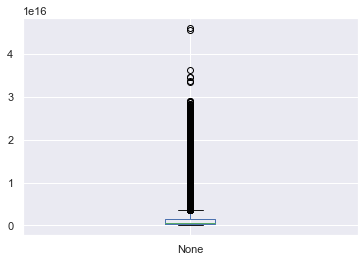

In [77]:
# boxplot to display outliers
pt_ft_diff.plot(kind='box')

plt.show()

In [78]:
# brief look at the outliers
outliers_case_1 = df.iloc[outliers_pt_ft.index]
outliers_case_1.head()

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disburse_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
521,664647,1500.0,1500.0,funded,Personal Housing Expenses,Housing,"To buy cement, iron, sand, bricks and hire wor...",SV,El Salvador,Osicala,...,USD,199.0,2014-01-31 21:43:39+00:00,2014-03-30 10:10:02+00:00,2014-01-28 08:00:00+00:00,2014-03-26 13:53:14+00:00,21.0,49,female,monthly
799,660131,1450.0,1450.0,funded,Agriculture,Agriculture,to buy agricultural inputs to protect and aid ...,HN,Honduras,Santa Barbara,...,HNL,269.0,2014-01-21 18:37:25+00:00,2014-03-26 22:25:57+00:00,2014-01-20 08:00:00+00:00,2014-03-17 22:04:55+00:00,26.0,56,female,monthly
1083,658101,350.0,350.0,funded,Personal Housing Expenses,Housing,"To buy cement, sand, and gravel for installing...",SV,El Salvador,NaN,...,USD,81.0,2014-01-16 15:05:46+00:00,2014-03-26 22:22:18+00:00,2013-12-20 08:00:00+00:00,2014-03-18 18:21:24+00:00,14.0,13,male,monthly
1474,658258,650.0,650.0,funded,Grocery Store,Food,to buy products for her grocery store,HN,Honduras,"Choloma, Cortes.",...,HNL,201.0,2014-01-16 20:45:39+00:00,2014-03-26 22:25:17+00:00,2014-01-08 08:00:00+00:00,2014-03-12 16:24:47+00:00,14.0,19,female,monthly
1519,419280,575.0,575.0,funded,Sewing,Services,NaN,CO,Colombia,NaN,...,COP,177.0,2012-04-25 12:45:24+00:00,2012-07-01 09:00:10+00:00,2012-04-23 07:00:00+00:00,2012-06-18 00:53:02+00:00,14.0,10,NaN,monthly


In [85]:
outliers_case_1.loc['months_to_fund'] = (outliers_case_1['funded_time'] - outliers_case_1['posted_time']).dt.days / 30

# planned_expiration_time columns in days
outliers_case_1.loc['planned_expiration_time_days'] = (outliers_case_1['planned_expiration_time'] - 
                                                   outliers_case_1['posted_time']).dt.days

# cases where months_to_fund > planned_expiration_time_days
outliers_case_1[outliers_case_1['months_to_fund'] > outliers_case_1['planned_expiration_time_days']]

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,posted_time,planned_expiration_time,disburse_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval,months_to_fund,planned_expiration_time_days


In this case, let us opt to keep the outliers

#### 'posted_time' and 'disbursed_time'

In [88]:
(df['posted_time'] - df['disburse_time']).describe()

count                    1416580
mean     12 days 04:36:06.951143
std      18 days 04:48:11.167029
min          -540 days +02:23:26
25%       5 days 19:58:28.750000
50%             14 days 02:57:52
75%      25 days 02:15:43.500000
max            118 days 16:28:59
dtype: object

As we have seen, the chronological order of these two dates does not matter, because the disbursal can be made before the posted time for most of the entities (Field partners). It is necessary to check for outliers, though.

Let us focus only when the disbursal is made before the posted_time.

In [90]:
# cases where the disbursal is made before the posted_time
pt_dt_pos = df[df['posted_time'] > df['disburse_time']]

# time difference between the two
pt_dt_pos_diff = pt_dt_pos['posted_time'] - pt_dt_pos['disburse_time']

# describe
pt_dt_pos_diff.describe()

count                    1273566
mean     16 days 14:42:00.922162
std       9 days 15:11:11.397535
min              0 days 00:00:03
25%       7 days 20:42:53.250000
50%      16 days 02:17:43.500000
75%             26 days 03:07:27
max            118 days 16:28:59
dtype: object

In [91]:
# outliers for the difference between posted_time and disbursed_time (when positive)
outliers_pt_dt = outliers_zscore(pt_dt_pos_diff, 3)

# describe
outliers_pt_dt.describe()

count    135.000000
mean       4.380002
std        1.411533
min        3.023692
25%        3.323745
50%        4.049502
75%        4.600418
max       10.596565
dtype: float64

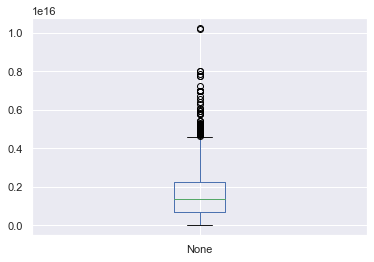

In [92]:
# boxplot
pt_dt_pos_diff.plot(kind='box')

plt.show()

In [94]:
# data regarding these outliers 
df.iloc[outliers_pt_dt.index].head()

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disburse_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
17072,114567,7450.0,7450.0,funded,Computers,Services,Training and certification for his computer an...,US,United States,"Atlanta, Georgia",...,USD,131.0,2009-06-10 20:14:22+00:00,NaT,2009-03-22 07:00:00+00:00,2009-06-21 02:37:18+00:00,26.0,236,male,monthly
17358,117254,175.0,175.0,funded,Pigs,Agriculture,To buy pig feed,PH,Philippines,"Surallah, South Cotabato",...,PHP,125.0,2009-06-22 00:58:11+00:00,NaT,2009-05-06 07:00:00+00:00,2009-06-22 02:05:24+00:00,6.0,6,female,bullet
17418,114264,5750.0,5750.0,funded,Services,Services,To buy a car for transporting packages,US,United States,"Queens, New York",...,USD,131.0,2009-06-09 16:55:37+00:00,NaT,2009-03-31 07:00:00+00:00,2009-06-20 20:18:43+00:00,27.0,171,male,monthly
36690,246230,1500.0,1500.0,funded,Butcher Shop,Food,To purchase meat for resale,KG,Kyrgyzstan,Tokmak,...,KGS,135.0,2010-11-09 05:39:58+00:00,NaT,2010-09-14 07:00:00+00:00,2010-11-15 18:34:32+00:00,7.0,46,"female, female, female, female",monthly
37027,245762,700.0,700.0,funded,Restaurant,Food,Purchase of ingredients,PH,Philippines,"Puerto Princesa, Palawan",...,PHP,145.0,2010-11-06 11:49:45+00:00,NaT,2010-09-20 07:00:00+00:00,2010-11-06 23:45:16+00:00,8.0,26,female,irregular


In [95]:
# the difference between the funded_time and posted_time in these outliers
(df.iloc[outliers_pt_dt.index]['funded_time'] - df.iloc[outliers_pt_dt.index]['posted_time']).describe()

count                        131
mean     14 days 13:25:41.870229
std      25 days 18:08:53.087114
min              0 days 01:07:13
25%              2 days 12:55:17
50%              6 days 23:02:20
75%      16 days 21:31:37.500000
max            242 days 17:25:56
dtype: object

There are a few outliers regarding this case. However, when analysing them, we notice that in all of them the difference between the posted_time and funded_time is acceptable, which means that although the disbursal was made long before the posted_time, the loan got funded almost immediatly. This could suggest that these cases were somehow managed by Kiva or the Field Partners.

Let us opt for their maintenance in the analysis.

#### 'funded_time' and 'disbursed_time'

In [99]:
(df['funded_time'] - df['disburse_time']).describe()

count                    1354847
mean     24 days 16:56:53.510977
std      19 days 18:17:54.516253
min          -183 days +15:28:03
25%      13 days 08:16:07.500000
50%             26 days 03:41:37
75%             36 days 08:18:57
max            157 days 06:55:22
dtype: object

Here let focus on the cases where the disbursed_time was filled after the loan was funded. Leave the cases where the disbursed_time appeared before the funded_time.

In [101]:
# cases where the disbursal is made after the funded_time
dt_ft_pos = df[df['disburse_time'] > df['funded_time']]

# time difference between the two
dt_ft_pos_diff = dt_ft_pos['disburse_time'] - dt_ft_pos['funded_time']

# describe
dt_ft_pos_diff.describe()

count                     117620
mean     16 days 07:46:33.561018
std      12 days 22:45:01.896489
min              0 days 00:00:17
25%             14 days 00:00:00
50%             14 days 00:00:00
75%             14 days 00:00:00
max            182 days 08:31:57
dtype: object

Let us now divide the analysis between the cases when there was a field partner involved and when there was not.

Field partner involved

In [103]:
# cases where the disbursal is made after the funded_time, where there is a field partner involved
dt_ft_pos_partner = df[(df['disburse_time'] > df['funded_time']) & (df['partner_id'].notnull())]

# time difference between the two
dt_ft_pos_diff_partner = dt_ft_pos_partner['disburse_time'] - dt_ft_pos_partner['funded_time']

# describe
dt_ft_pos_diff_partner.describe()

count                     104590
mean     17 days 06:47:49.884291
std      12 days 20:47:08.139505
min              0 days 00:01:24
25%             14 days 00:00:00
50%             14 days 00:00:00
75%             14 days 00:00:00
max             88 days 23:25:52
dtype: object

In [104]:
# outliers for the difference between disbursed_time and funded_time with a threshold = 3, with a field partner
outliers_dt_ft_partner = outliers_zscore(dt_ft_pos_diff_partner, 3)

# describe
outliers_dt_ft_partner.describe()

count    3214.000000
mean        4.192525
std         0.765157
min         3.002844
25%         3.487668
50%         4.166138
75%         4.916974
max         5.572261
dtype: float64

In [106]:
# cases where the disbursal is made after the funded_time, where there is not a field partner involved
dt_ft_pos_partner_not = df[(df['disburse_time'] > df['funded_time']) & (df['partner_id'].isnull())]

# time difference between the two
dt_ft_pos_diff_partner_not = dt_ft_pos_partner_not['disburse_time'] - dt_ft_pos_partner_not['funded_time']

# describe
dt_ft_pos_diff_partner_not.describe()

count                      13030
mean      8 days 14:59:16.826477
std      10 days 20:39:23.626387
min              0 days 00:00:17
25%       2 days 20:21:33.750000
50%              5 days 12:25:15
75%       9 days 13:06:44.250000
max            182 days 08:31:57
dtype: object

In [107]:
# outliers for the difference between disbursed_time and funded_time with a threshold = 3, and NO field partner
outliers_dt_ft_partner_not = outliers_zscore(dt_ft_pos_diff_partner_not, 3)

# describe
outliers_dt_ft_partner_not.describe()

count    301.000000
mean       4.579016
std        1.698910
min        3.001596
25%        3.346945
50%        3.989094
75%        5.169267
max       15.996315
dtype: float64

In [108]:
# distribution among countries of the outliers with a field partner involved
df.iloc[outliers_dt_ft_partner.index].country_name.value_counts().head(15)

Philippines    599
Kenya          375
Cambodia       192
Peru           153
El Salvador    150
Nicaragua      109
Uganda         101
Tajikistan      98
Pakistan        85
Colombia        78
Ecuador         75
Nigeria         64
India           61
Paraguay        60
Ghana           59
Name: country_name, dtype: int64

In [110]:
# distribution among countries of the outliers with no field partner involved
df.iloc[outliers_dt_ft_partner_not.index].country_name.value_counts().head(15)

Kenya            76
Philippines      48
Peru             21
Tajikistan       11
Nicaragua        11
United States     8
Pakistan          7
Uganda            7
Cambodia          7
Ghana             7
Ecuador           7
Sierra Leone      6
El Salvador       6
Bolivia           5
Mongolia          5
Name: country_name, dtype: int64

Looking at the distribution of the outliers among countries, however, we notice that they are somewhat representative, either with or without a partner involved, so let us opt to keep the values for further analysis.

#### When there is a missing disbursed_time value and the loan has been funded: (Kenya & USA)

In [112]:
# Cases where there is a missing disbursed_time and the loan has been funded
missing_disb = df[(df['disburse_time'].isna()) & (df['funded_time'].notnull())]
missing_disb.count().funded_time

271

In [113]:
# head
missing_disb.head()

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disburse_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
37765,1407950,8000.0,8000.0,funded,Clothing,Clothing,support a local business dedicated to providin...,US,United States,NaN,...,USD,NaN,2017-11-02 01:11:32+00:00,2017-12-17 22:44:40+00:00,NaT,2017-12-16 21:14:45+00:00,36.0,56,male,bullet
70179,1164746,3000.0,3000.0,refunded,Services,Services,NaN,US,United States,NaN,...,USD,NaN,2016-10-05 01:28:13+00:00,2016-11-10 18:43:40+00:00,NaT,2016-11-10 00:40:29+00:00,24.0,57,NaN,bullet
70314,1088448,5000.0,5000.0,refunded,Agriculture,Agriculture,NaN,US,United States,NaN,...,USD,NaN,2015-04-15 12:35:57+00:00,2015-06-05 00:30:01+00:00,NaT,2016-02-11 17:44:48+00:00,30.0,106,NaN,bullet
89049,1428619,2000.0,2000.0,funded,Entertainment,Entertainment,fund the renovation of my retail store so my b...,US,United States,NaN,...,USD,NaN,2017-12-05 18:50:15+00:00,2018-01-20 12:38:16+00:00,NaT,2017-12-23 14:32:29+00:00,18.0,25,male,bullet
91347,1084914,125.0,125.0,refunded,Clothing,Clothing,NaN,KE,Kenya,NaN,...,KES,NaN,2014-10-28 06:32:19+00:00,2014-12-27 17:45:36+00:00,NaT,2014-12-26 19:09:42+00:00,3.0,12,NaN,bullet


In [114]:
# geographical location of the missing values
missing_disb.country_name.value_counts()

Kenya            216
United States     55
Name: country_name, dtype: int64

In [115]:
# sector name of those missing values 
missing_disb.sector_name.value_counts()

# Note: 97% of the Agriculture cases are from Kenya

Agriculture       79
Food              46
Services          46
Retail            44
Clothing          26
Arts               9
Transportation     7
Construction       5
Health             4
Entertainment      4
Education          1
Name: sector_name, dtype: int64

Since the missing values appear in only two countries in the world, let us generalize and check for outliers by comparing them with the typical delay to disburse in each country.

#### USA

In [117]:
# cases in the United States where the disbursal is made after the loan is funded
usa_dt_ft_pos = dt_ft_pos[dt_ft_pos['country_name'] == 'United States']

# delay values 
delay_usa = (usa_dt_ft_pos['disburse_time'] - usa_dt_ft_pos['funded_time'])

# description of the delay to disburse in the United States
print(delay_usa.describe())

# I will consider the mean value for the typical delay to disburse in the United States
delay_usa.mean()

count                      3527
mean     5 days 06:43:32.021831
std      5 days 22:55:18.397383
min             0 days 00:00:17
25%             2 days 00:26:18
50%             3 days 23:05:12
75%      6 days 05:07:38.500000
max           106 days 12:48:50
dtype: object


Timedelta('5 days 06:43:32.021831')

#### Kenya

In [118]:
# cases in Kenya where the disbursal is made after the loan is funded
kenya_dt_ft_pos = dt_ft_pos[dt_ft_pos['country_name'] == 'Kenya']

# delay values 
delay_kenya = (kenya_dt_ft_pos['disburse_time'] - kenya_dt_ft_pos['funded_time'])

# description of the delay to disburse in Kenya
print(delay_kenya.describe())

# I will consider the mean value for the typical delay to disburse in Kenya
delay_kenya.mean()

count                      20659
mean     17 days 11:42:49.691708
std      17 days 07:31:00.633473
min              0 days 00:02:00
25%              5 days 06:34:47
50%             13 days 12:58:22
75%      24 days 14:37:12.500000
max            182 days 08:31:57
dtype: object


Timedelta('17 days 11:42:49.691708')

In [120]:
# missing values filtered by country: Kenya
kenya = missing_disb[missing_disb['country_name'] == 'Kenya']

# description of the delay of disbursal, in Kenya, after the loan is funded
(max(data['disburse_time']) - kenya['funded_time']).describe()

count                          216
mean     1011 days 06:15:02.481481
std       147 days 12:35:07.238205
min              914 days 11:19:07
25%              921 days 01:30:39
50%       942 days 19:49:48.500000
75%             1023 days 09:07:22
max             1600 days 10:20:21
Name: funded_time, dtype: object

In [121]:
# removing the rows
df = df.drop(missing_disb.index)

# new shape
df.shape

(1419122, 21)

Now that the data is clean, we want to start by studying the characteristics of the main variables and how they interacted with each other over time.

#### Evolution of the number of loans in each phase: 2006-2017

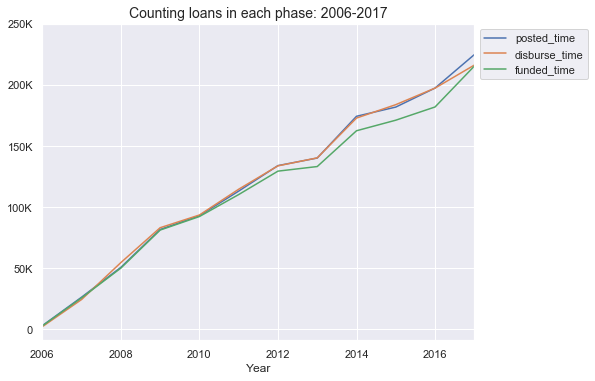

In [123]:
# 2006 - 2017

# main variables
df[df['posted_time'].notnull()]['posted_time'].dt.year.value_counts().sort_index()[:-1].plot(grid=True)
df[df['disburse_time'].notnull()]['disburse_time'].dt.year.value_counts().sort_index()[:-1].plot(grid=True)
df[df['funded_time'].notnull()]['funded_time'].dt.year.value_counts().sort_index()[:-1].plot(grid=True)

# formatting
plt.yticks([0, 50000, 100000, 150000, 200000, 250000], ['0', '50K', '100K', '150K', '200K', '250K'])
plt.xlabel("Year")
plt.title("Counting loans in each phase: 2006-2017", fontsize=14)
plt.legend(bbox_to_anchor=(1, 1))
plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.show()

In a first look, we notice three major time periods:

Until 2010, the number of posted loans were closely matched in time by the amount of funding and disbursals. After that, between 2010 and 2014, we started to see a clear separation between each of the main variables: it suggests that the loans, continuing with almost always a close match between the posting phase and disbursal, started to lose its efficiency regarding the funding of the projects.

After 2014 till the end, the differences continued to aggravate between the postings and funding, and the number of disbursals and postings became just a bit volatile over time. Curiously, the number of funding gained proximity with the number of disbursals, especially in the last year.

Still, this could be related to missing values or other factors, so it deserves further exploration.

#### 2006-2010

C:\Users\sandhya.mukkamala\PycharmProjects\Conda\lib\site-packages\pandas\plotting\_matplotlib\core.py:1085: UserWarning: Attempting to set identical left == right == 2008.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


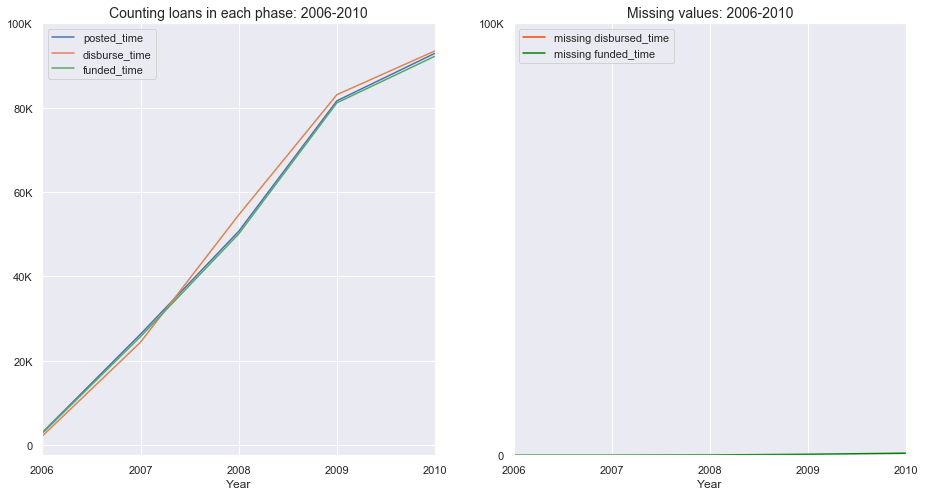

In [126]:
# 2006 - 2010

# main variables
plt.subplot(1, 2, 1)
df[df['posted_time'].notnull()]['posted_time'].dt.year.value_counts().sort_index()[:-8].plot(grid=True)
df[df['disburse_time'].notnull()]['disburse_time'].dt.year.value_counts().sort_index()[:-8].plot(grid=True)
df[df['funded_time'].notnull()]['funded_time'].dt.year.value_counts().sort_index()[:-8].plot(grid=True)

# formatting
plt.yticks([0, 20000, 40000, 60000, 80000, 100000], ['0', '20K', '40K', '60K', '80K', '100K'])
plt.locator_params(axis='x', nbins=5)
plt.xlabel("Year")
plt.title("Counting loans in each phase: 2006-2010", fontsize=14)
plt.legend(loc='upper left')


# missing values
plt.subplot(1, 2, 2)
df[df['disburse_time'].dt.year.isna()]['posted_time'].dt.year.value_counts().sort_index()[:1].plot(grid=True, label="missing disbursed_time", color='orangered')
data[data['funded_time'].dt.year.isna()]['posted_time'].dt.year.value_counts().sort_index()[:5].plot(grid=True, label="missing funded_time", color='green')

# formatting
plt.yticks([0, 100000], ['0', '100K'])
plt.locator_params(axis='x', nbins=5)
plt.xlabel("Year")
plt.title("Missing values: 2006-2010", fontsize=14)
plt.legend(loc='upper left')

plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0.2, hspace=0.4)
plt.show()

As said before, the process was smooth until 2010.

#### 2010-2014

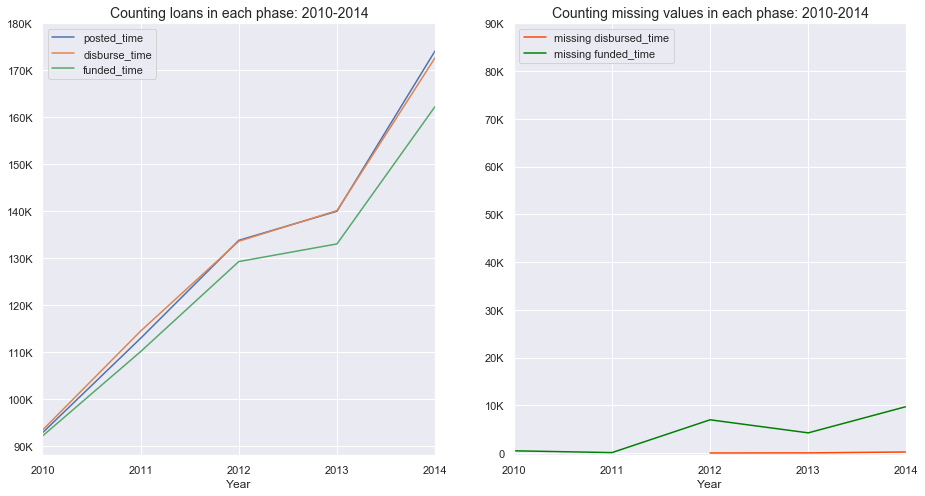

In [127]:
# 2010 - 2014

# main variables
plt.subplot(1, 2, 1)
df[df['posted_time'].notnull()]['posted_time'].dt.year.value_counts().sort_index()[4:9].plot(grid=True)
df[df['disburse_time'].notnull()]['disburse_time'].dt.year.value_counts().sort_index()[4:9].plot(grid=True)
df[df['funded_time'].notnull()]['funded_time'].dt.year.value_counts().sort_index()[4:9].plot(grid=True)

# formatting
plt.yticks([90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000], ['90K', '100K', '110K', '120K', '130K', '140K', '150K', '160K', '170K', '180K'])
plt.locator_params(axis='x', nbins=5)
plt.xlabel("Year")
plt.title("Counting loans in each phase: 2010-2014", fontsize=14)
plt.legend(loc= 'upper left')


# missing values
plt.subplot(1, 2, 2)
df[df['disburse_time'].isna()]['posted_time'].dt.year.value_counts().sort_index()[1:4].plot(grid=True, label="missing disbursed_time", color='orangered')
df[df['funded_time'].isna()]['posted_time'].dt.year.value_counts().sort_index()[4:9].plot(grid=True, label="missing funded_time", color='green')

# formatting
# plt.yticks([0, 2000, 4000, 6000, 8000, 10000], ['0', '2K', '4K', '6K', '8K', '10K'])
# plt.yticks([0, 10000, 20000, 180000], ['0', '10K', '20K', '180K'])
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000], ['0', '10K', '20K', '30K', '40K', '50K', '60K', '70K', '80K', '90K'])
plt.locator_params(axis='x', nbins=5)
plt.xlabel("Year")
plt.title("Counting missing values in each phase: 2010-2014", fontsize=14)
plt.legend(loc= 'upper left')

plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0.2, hspace=0.4)
plt.show()

Between 2010 and 2014, the funding started to lose track of the posted loans mainly between 2010 and 2011. This difference, however, could be due to the cyclical nature of the process, as it will be shown below. Thereafter, the difference was mostly due to the funded missing values.

#### 2014-2017

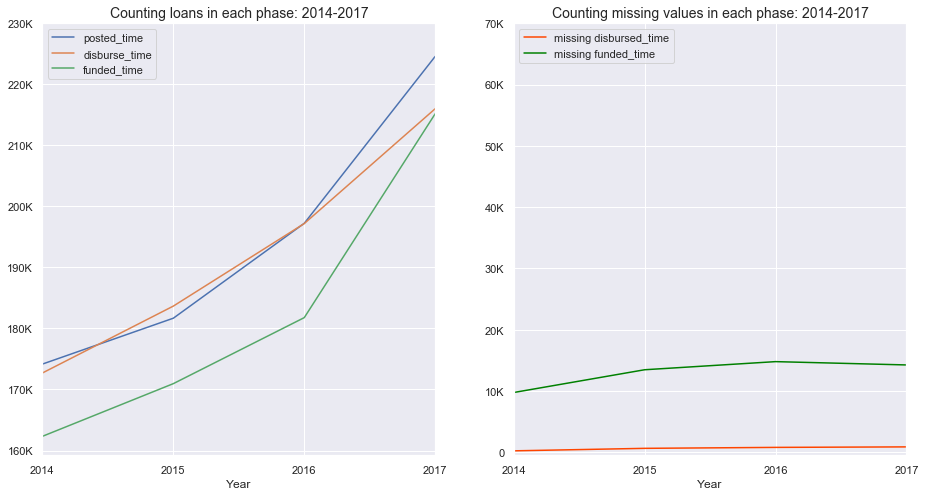

In [128]:
# 2014 - 2017

# main variables 
plt.subplot(1, 2, 1)
df[df['posted_time'].notnull()]['posted_time'].dt.year.value_counts().sort_index()[8:-1].plot(grid=True)
df[df['disburse_time'].notnull()]['disburse_time'].dt.year.value_counts().sort_index()[8:-1].plot(grid=True)
df[df['funded_time'].notnull()]['funded_time'].dt.year.value_counts().sort_index()[8:-1].plot(grid=True)

# formatting
plt.yticks([160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000], ['160K', '170K', '180K', '190K', '200K', '210K', '220K', '230K'])
plt.locator_params(axis='x', nbins=5)
# plt.locator_params(axis='y', nbins=5) 
plt.xlabel("Year")
plt.title("Counting loans in each phase: 2014-2017", fontsize=14)
plt.legend(loc= 'upper left')


# missing values
plt.subplot(1, 2, 2)
df[df['disburse_time'].isna()]['posted_time'].dt.year.value_counts().sort_index()[3:].plot(grid=True, label="missing disbursed_time", color='orangered')
df[df['funded_time'].isna()]['posted_time'].dt.year.value_counts().sort_index()[8:-1].plot(grid=True, label="missing funded_time", color='green')

# formatting
# plt.yticks([0, 4000, 8000, 12000, 16000], ['0', '4K', '8K', '12K', '16K'])
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000], ['0', '10K', '20K', '30K', '40K', '50K', '60K', '70K'])
plt.locator_params(axis='x', nbins=5)
plt.xlabel("Year")
plt.title("Counting missing values in each phase: 2014-2017", fontsize=14)
plt.legend(loc= 'upper left')

plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0.2, hspace=0.4)
plt.show()

In the last phase, although the difference between the number of missing values of the disbursals and fundings remained relatively constant, the number of fundings augmented more than disbursals, equalizing them on the final stretch.

We can see that the deviation increase was mostly due to missing values until 2014. If we take that apart, the lines are somewhat at the same pace. This was not the case during the final 4 years, given the disbursals data we have. However, since it captures data at the end of the scale, and given the cyclical nature of the Kiva process, as shown below, it could still be related to the fact that the disbursal data was not yet inserted, lagging a few days or weeks.

In conclusion, we see that from 2006 till 2010 the process was smooth and without significant delays. The number of loans not funded started then to increase year after year until 2017, ending with approximately 15K loans to fund. This does not means delays got significantly worse year after year, but they're there.

#### The cyclical nature of the Kiva process

When looking at the disaggregation by month, we can see the <font color=orange>cyclical nature</font> of the journey of Kiva loans.

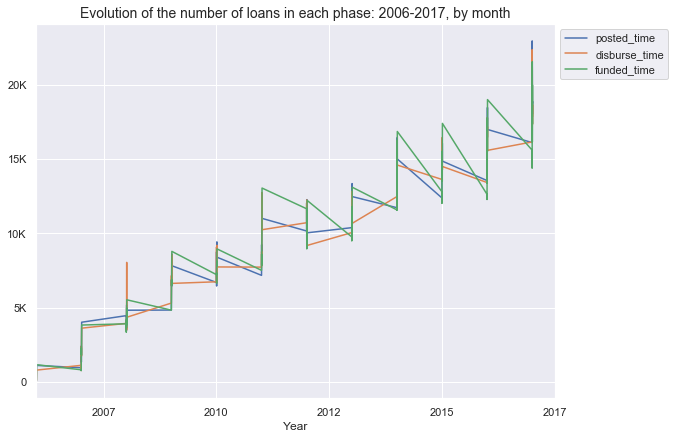

In [129]:
# evolution of the main variables, by month
evol_posted = df[df['posted_time'].notnull()]['posted_time']
evol_disbursed = df[df['disburse_time'].notnull()]['disburse_time']
evol_funded = df[df['funded_time'].notnull()]['funded_time']

# plot months (except 2018)
evol_posted.map(lambda x: 1000*x.year + x.month).value_counts().sort_index()[:-2].plot(grid=True)
evol_disbursed.map(lambda x: 1000*x.year + x.month).value_counts().sort_index()[:-4].plot(grid=True)
evol_funded.map(lambda x: 1000*x.year + x.month).value_counts().sort_index()[:-2].plot(grid=True)

plt.locator_params(axis='x', nbins=5)
plt.xticks([2007500, 2010000, 2012500, 2015000, 2017500], ["2007", "2010", "2012", "2015", "2017"])
plt.yticks([0, 5000, 10000, 15000, 20000], ["0", "5K", "10K", "15K", "20K"])
plt.xlabel("Year")
plt.title("Evolution of the number of loans in each phase: 2006-2017, by month", fontsize=14)
plt.legend(bbox_to_anchor=(1, 1))

plt.subplots_adjust(left=0, bottom=-0.3, right=1.2, top=1, wspace=0.6, hspace=0.4)
plt.show()

These cycles suggest that Kiva gather many loan requests before they post on their website. The fundings and disbursals follow the announcements (or, since the disbursal is almost always the first to occur, the posting and funding follow the disbursals).

To further examine this cyclical nature, let us now display the aggregated values by month and finally, by day.

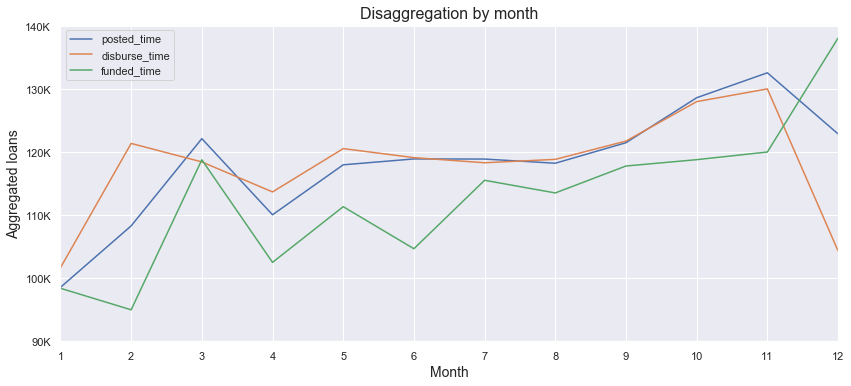

In [131]:
# Display aggregated values, by month

# posted_time
posted_time_months = df['posted_time'].dt.month
posted_time_by_months = df['posted_time'].groupby(posted_time_months).count()
posted_time_by_months.plot()

# disbursed_time
disbursed_time_months = df['disburse_time'].dt.month
disbursed_time_by_months = df['disburse_time'].groupby(disbursed_time_months).count()
disbursed_time_by_months.plot()

# funded_time
funded_time_months = df['funded_time'].dt.month
funded_time_by_months = df['funded_time'].groupby(funded_time_months).count()
funded_time_by_months.plot()

plt.subplots_adjust(left=0, bottom=-0.1, right=1.8, top=1, wspace=0.6, hspace=0.4)
plt.title("Disaggregation by month", fontsize=16)
plt.xticks(range(1, 13))
plt.yticks([90000, 100000, 110000, 120000, 130000, 140000], ["90K", "100K", "110K", "120K", "130K", "140K"])
plt.ylabel("Aggregated loans", fontsize=14)
plt.xlabel("Month", fontsize=14)
plt.legend(['posted_time', 'disburse_time', 'funded_time'])
plt.show()

As we can see, there is a slight tendency to post, disburse and fund as the year comes to an end.

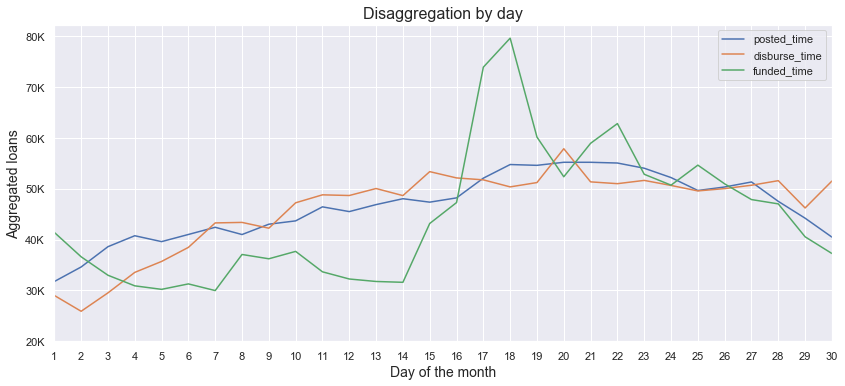

In [133]:
# Display aggregated values, by day

# posted_time
posted_time_days = df['posted_time'].dt.day
posted_time_by_days = df['posted_time'].groupby(posted_time_days).count()
posted_time_by_days.iloc[:-1].plot()

# disbursed_time
disbursed_time_days = df['disburse_time'].dt.day
disbursed_time_by_days = df['disburse_time'].groupby(disbursed_time_days).count()
disbursed_time_by_days.iloc[:-1].plot()

# funded_time
funded_time_days = data['funded_time'].dt.day
funded_time_by_days = data['funded_time'].groupby(funded_time_days).count()
funded_time_by_days.iloc[:-1].plot()

plt.subplots_adjust(left=0, bottom=-0.1, right=1.8, top=1, wspace=0.6, hspace=0.4)
plt.title("Disaggregation by day", fontsize=16)
plt.xticks(range(1, 31))
plt.yticks([20000, 30000, 40000, 50000, 60000, 70000, 80000], ["20K", "30K", "40K", "50K", "60K", "70K", "80K"])
plt.ylabel("Aggregated loans", fontsize=14)
plt.xlabel("Day of the month", fontsize=14)
plt.legend(['posted_time', 'disburse_time', 'funded_time'])
plt.show()

While the posting and disbursing periods relatively aggregate the same amount of loans throughout the month, there is a strong pressure to fund the loans during the 3rd week of the month.

#### Now, looking at the time differences between the main variables
#### 'posted_time' vs 'disbursed_time'

In [134]:
# posted_time - disbursed_time
post_disb = df['posted_time'] - df['disburse_time']

In [135]:
post_disb.describe()

count                    1416580
mean     12 days 04:36:06.951143
std      18 days 04:48:11.167029
min          -540 days +02:23:26
25%       5 days 19:58:28.750000
50%             14 days 02:57:52
75%      25 days 02:15:43.500000
max            118 days 16:28:59
dtype: object

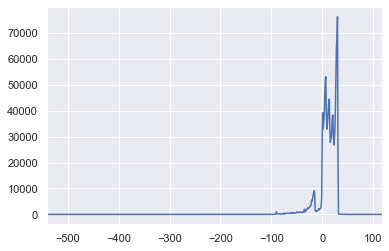

In [136]:
# Glimpse of the distribution
post_disb.dt.days.value_counts().sort_index().plot()

In [137]:
# difference between disbursal and posting between -35 and +32 days, in percentage
print("Between -35 and +32 days:", int(round(post_disb.dt.days.value_counts().sort_index()[-35:32].sum() / 
                                             post_disb.dt.days.value_counts().sum()*100)), "%")

# difference between disbursal and posting between 0 and +32 days, in percentage
print("Between 0 and +32 days:", int(round(post_disb.dt.days.value_counts().sort_index()[0:32].sum() / 
                                           post_disb.dt.days.value_counts().sum()*100)), "%")

Between -35 and +32 days: 98 %
Between 0 and +32 days: 90 %


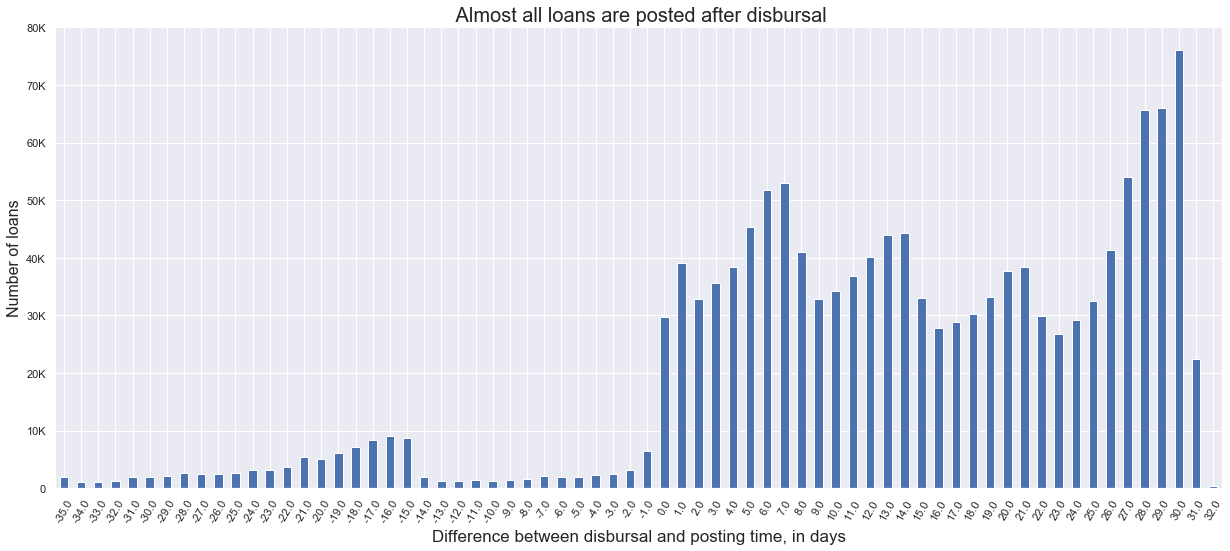

In [138]:
# distribution of 98% of the selected data
post_disb.dt.days.value_counts().sort_index()[-35:32].plot(kind='bar')

# formatting
plt.title(" Almost all loans are posted after disbursal", fontsize=20)
plt.xticks(rotation=60)
plt.xlabel("Difference between disbursal and posting time, in days", fontsize=17)
plt.ylabel("Number of loans", fontsize=16)
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000], 
           ['0', '10K', '20K', '30K', '40K', '50K', '60K', '70K', '80K'])

plt.subplots_adjust(left=0, bottom=-0.6, right=2.7, top=1, wspace=0.6, hspace=0.4)
plt.show()

98% of the differences between the time of disbursal and posting of loans occur on a range of -35 days and +32 days.   

Moreover, 90% of the differences are positive, that is, pre-disbursals.

#### As we can confirm, most (at least 90%) of the disbursals are made by field partners, the only ones who can pre-disburse.

#### 'posted_time' vs 'funded_time'

In [140]:
# funded_time - posted_time
fund_post = df['funded_time'] - df['posted_time']

In [141]:
fund_post.describe()

count                    1354847
mean     12 days 14:55:24.936868
std      13 days 11:14:07.002439
min              0 days 00:02:00
25%       3 days 13:14:12.500000
50%              7 days 18:27:30
75%      18 days 11:31:19.500000
max            533 days 17:22:00
dtype: object

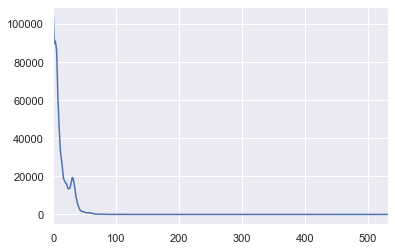

In [142]:
# Glimpse of the distribution
fund_post.dt.days.value_counts().sort_index().plot()

In [143]:
# difference between funding and posting between 0 and +50 days, in percentage
print("Between 0 and +50 days:", int(round(fund_post.dt.days.value_counts().sort_index()[0:50].sum() /
                                           fund_post.dt.days.value_counts().sum()*100)), "%")

# difference between funding and posting between 0 and +30 days, in percentage
print("Between 0 and +30 days:", int(round(fund_post.dt.days.value_counts().sort_index()[0:30].sum() /
                                           fund_post.dt.days.value_counts().sum()*100)), "%")

Between 0 and +50 days: 99 %
Between 0 and +30 days: 89 %


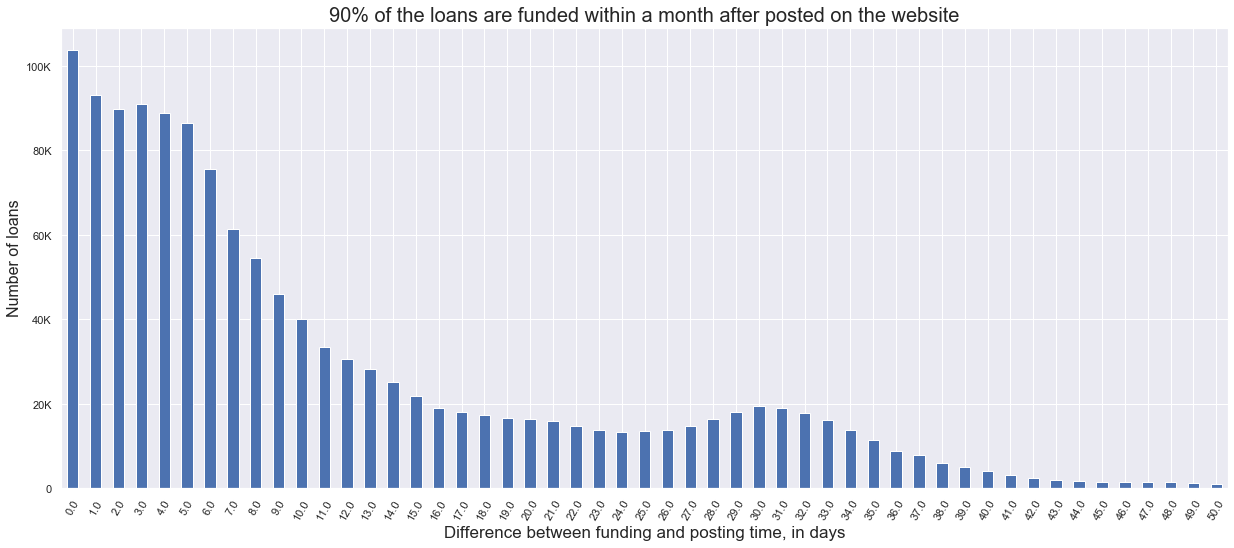

In [144]:
# distribution of 99% of the selected data
fund_post.dt.days.value_counts().sort_index()[0:50].plot(kind='bar')

# formatting
plt.title("90% of the loans are funded within a month after posted on the website", fontsize=20)
plt.xticks(rotation=60)
plt.xlabel("Difference between funding and posting time, in days", fontsize=17)
plt.ylabel("Number of loans", fontsize=16)
plt.yticks([0, 20000, 40000, 60000, 80000, 100000], ['0', '20K', '40K','60K', '80K', '100K'])

plt.subplots_adjust(left=0, bottom=-0.6, right=2.7, top=1, wspace=0.6, hspace=0.4)
plt.show()

When we look at the time a loan takes to get funded since the time it is posted on Kiva website, we see that 99% of them are funded within 50 days, and almost 90% within 30 days.     

This barplot suggests that the time between posting and funding could be described as an Exponential distribution. I will create an Empirical CDF of these time differences and compare it with a theoretical CDF.

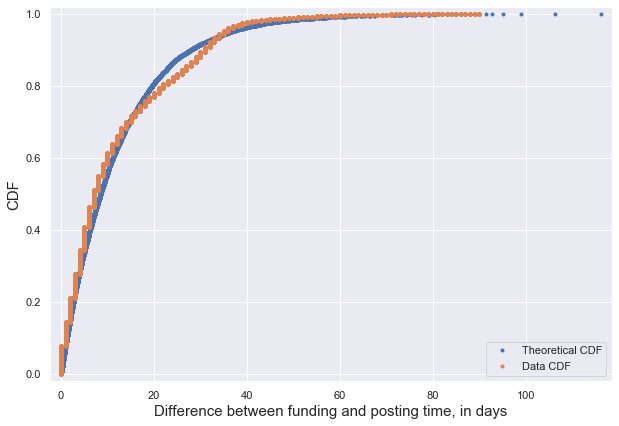

In [145]:
# ECDF function
def ecdf(df):
    """Compute ECDF for a one-dimensional array of measurements."""
    x = np.sort(df)
    y = np.arange(1, len(df) + 1) / len(df)
    return x, y

# time differences between funding and posting times array
fund_post_array = fund_post.dt.days

# within 90 days (99%)
fund_post_array_90 = fund_post_array[fund_post_array.between(0, 90)]


# ECDF from the data: x, y
x, y = ecdf(fund_post_array_90)

# Drawing an exponential distribution with parameter tau
tau = np.mean(fund_post_array_90)
theor = np.random.exponential(tau, 10000)

# constructing the CDF from theoretical samples: x_theor, y_theor
x_theor, y_theor = ecdf(theor)

# Overlaying the plots
plt.plot(x_theor, y_theor, marker='.', linestyle='none')
plt.plot(x, y, marker='.', linestyle='none')

# Margins and axis labels
plt.margins(0.02)
plt.xlabel("Difference between funding and posting time, in days", fontsize=15)
plt.ylabel('CDF', fontsize=15)
plt.legend(('Theoretical CDF', 'Data CDF'), loc='lower right')

# Show the plot
plt.subplots_adjust(left=0, bottom=-0.3, right=1.3, top=1, wspace=0, hspace=0)
plt.show()

It seems to fit an exponential distribution.

#### 'disbursed_time' vs 'funded_time'     

Now, since we know that most of the loans are pre-disbursed, we should now take a look at the combination of the two previous analysis, that is, at the difference between the time of disbursal and funding.

In [147]:
# funded_time - disbursed_time
fund_disb = df['funded_time'] - df['disburse_time']

In [149]:
fund_disb.describe()

count                    1354847
mean     24 days 16:56:53.510977
std      19 days 18:17:54.516253
min          -183 days +15:28:03
25%      13 days 08:16:07.500000
50%             26 days 03:41:37
75%             36 days 08:18:57
max            157 days 06:55:22
dtype: object

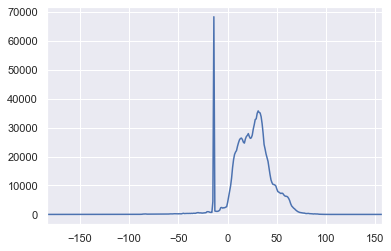

In [150]:
# Glimpse of the distribution
fund_disb.dt.days.value_counts().sort_index().plot()

In [151]:
# difference between funding and disbursal between -18 and +70 days
print("between -18 and +70 days:", int(round(fund_disb.dt.days.value_counts().sort_index()[-18:70].sum()/
                                             fund_disb.dt.days.value_counts().sum()*100)), "%")

# when the disbursal occurs only after the funding is complete
print("disbursal after funding:", int(round(fund_disb.dt.days.value_counts().sort_index()[-3000:0].sum()/
                                            fund_disb.dt.days.value_counts().sum()*100)), "%")

# when the disbursal occurs until 14 days after the loan is funded
print("disbursal after funding (until 14 days):", int(round(fund_disb.dt.days.value_counts().sort_index()[-14:0].sum()/
                                                            fund_disb.dt.days.value_counts().sum()*100)), "%")

# when the disbursal occurs 14 days after the loan is funded
print("disbursal after funding (14th day):", int(round(fund_disb.dt.days.value_counts().sort_index()[-14].sum()/
                                                       fund_disb.dt.days.value_counts().sum()*100)), "%")

between -18 and +70 days: 98 %
disbursal after funding: 9 %
disbursal after funding (until 14 days): 7 %
disbursal after funding (14th day): 5 %


In [152]:
# difference between funding and disbursal between 0 and +30 days
print(int(round(fund_disb.dt.days.value_counts().sort_index()[0:30].sum()/
                fund_disb.dt.days.value_counts().sum()*100)))

# difference between funding and disbursal between 0 and +60 days
print(int(round(fund_disb.dt.days.value_counts().sort_index()[0:60].sum()/
                fund_disb.dt.days.value_counts().sum()*100)))

53
88


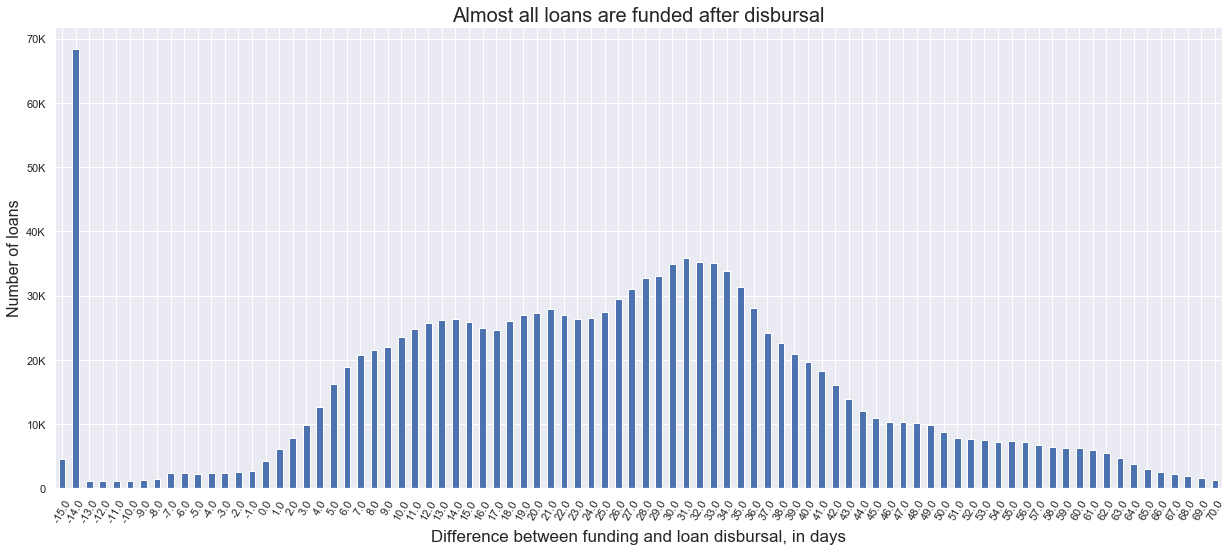

In [153]:
# distribution of 98% of the total data
fund_disb.dt.days.value_counts().sort_index()[-15:70].plot(kind='bar')

# formatting
plt.title("Almost all loans are funded after disbursal", fontsize=20)
plt.xticks(rotation=60)
plt.xlabel("Difference between funding and loan disbursal, in days", fontsize=17)
plt.ylabel("Number of loans", fontsize=16)
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000], ['0', '10K', '20K', '30K', '40K', '50K', '60K', '70K'])

plt.subplots_adjust(left=0, bottom=-0.6, right=2.7, top=1, wspace=0.6, hspace=0.4)
plt.show()

As we can see, close to 10% of the total loans are disbursed after the funding is complete, and 5% occur 14 days after the time of funding.

In most cases, a pre-disbursal occurs and only then the funding period commences.

Confirming if the 5% cases where disbursal occurs 14 days after funding are distributed over time or concentrated in a few occasions:

In [155]:
# when disbursal occurs 14 days after funding time
forteen_days = df[(df['funded_time'] - df['disburse_time']).dt.days == -14]['funded_time']

# in how many months this occurs
forteen_days.map(lambda x: 1000*x.year + x.month).value_counts().sort_index().count()

127

It is regular over time, suggesting, again, the cyclical nature of the loan process.

#### Real time to fund

Since this analysis includes cases where the disbursal occurs after the posting time, now we will look at the real time a loan takes to get funded. To do that, we need the difference between the funding time and the disbursal or posting time, depending on which of these occurred first.

In [157]:
# total differences
start_1 = df[df['posted_time'] < df['disburse_time']]
start_2 = df[df['posted_time'] > df['disburse_time']]

# loan time 1 & 2
loan_time_1 = start_1['funded_time'] - start_1['posted_time']
loan_time_2 = start_2['funded_time'] - start_2['disburse_time']

#concatenate
loan_time = pd.concat([loan_time_1.dt.days, loan_time_2.dt.days], axis=0)

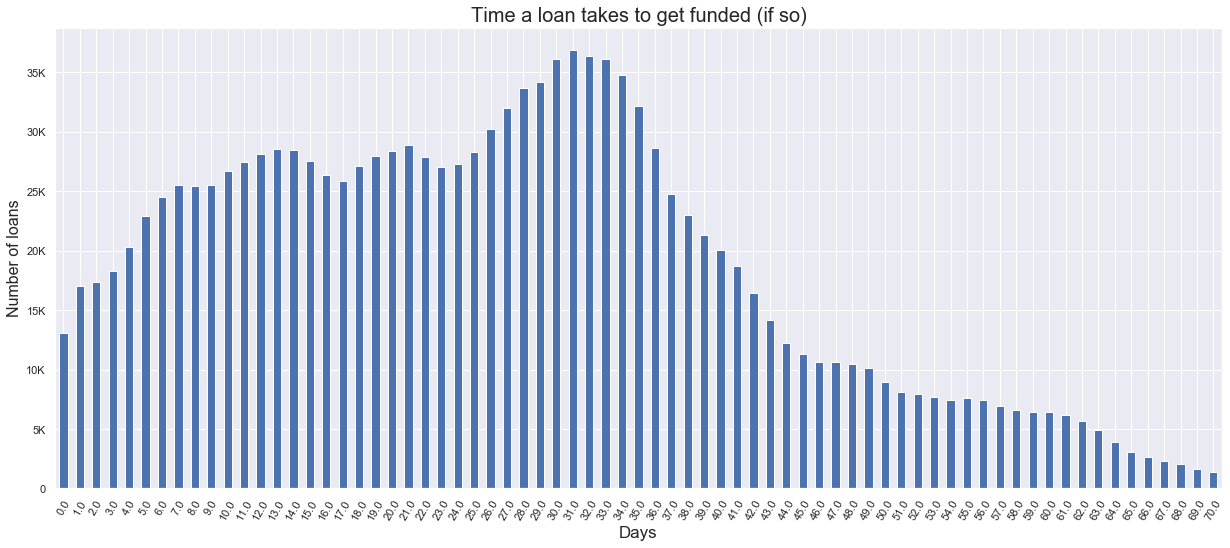

In [158]:
# 99% of the data
loan_time_99 = loan_time.value_counts().sort_index()[0:70]

# distribution
loan_time_99.plot(kind='bar')

# formatting
plt.title("Time a loan takes to get funded (if so)", fontsize=20)
plt.xticks(rotation=60)
plt.xlabel("Days", fontsize=17)
plt.ylabel("Number of loans", fontsize=16)
plt.yticks([0, 5000, 10000, 15000, 20000, 25000, 30000, 35000], ['0', '5K', '10K','15K', '20K', '25K', '30K', '35K'])

plt.subplots_adjust(left=0, bottom=-0.6, right=2.7, top=1, wspace=0.6, hspace=0.4)
plt.show()

In [159]:
# percentage of loans that get funded within 17 days
print("17 days:", int(round(loan_time.value_counts().sort_index()[0:17].sum()/loan_time.value_counts().sum()*100)), "%")

# percentage of loans that get funded within a month
print("32 days:", int(round(loan_time.value_counts().sort_index()[0:32].sum()/loan_time.value_counts().sum()*100)), "%")

# percentage of loans that get funded within 2 months and 10 days
print("70 days:", int(round(loan_time.value_counts().sort_index()[0:70].sum()/loan_time.value_counts().sum()*100)), "%")

17 days: 32 %
32 days: 66 %
70 days: 99 %


In [161]:
# loans not funded yet
print(round(df[(df['posted_time'].notnull()) & (df['funded_time'].isnull())].count().loan_id/df.posted_time.count()*100), "%")

5.0 %


5% of all loans are not funded yet. Of those that are:

<font color=orange>Close to 60% are funded within a month.</font> This happens almost in a linear way as the month advances.
<font color=orange>99% are funded within 2 months and 10 days.</font>
As a reminder, 9% of the total loans are only disbursed after they are funded (with 7% within two weeks).

#### Is it a normal distribution?

In [162]:
# represented data
rep_loan = loan_time[loan_time.between(0, 70)]

# D'Agostino's K-squared test
stat, p_value = normaltest(rep_loan)
print("D'Agostino's K-squared test: statistic=%.3f; p-value=%.3f" % (stat, p_value))

D'Agostino's K-squared test: statistic=46105.594; p-value=0.000


Assuming a significance level of 1%, we have sufficient statistical evidence to reject the hypothesis that assumes that the time a loan takes to get funded follows a normal distribution.

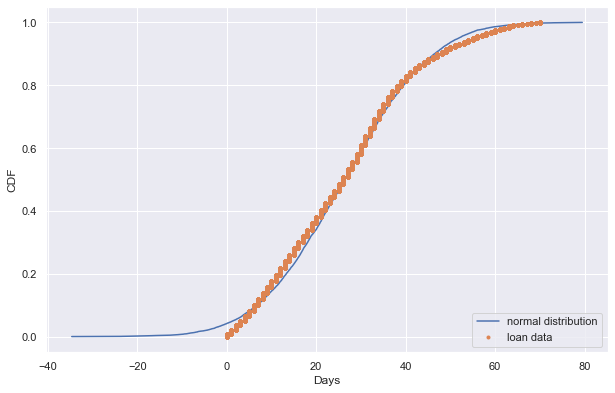

In [163]:
# ECDF

# mean and standard deviation of the data
mean_loan_time = np.mean(rep_loan)
std_loan_time = np.std(rep_loan)

# 10,000 samples out of a normal distribution with mean_temp and std_temp
samples = np.random.normal(mean_loan_time, std_loan_time, size=10000)

# CDF of the samples and of the temperature data
x_theor, y_theor = ecdf(samples)
x, y = ecdf(rep_loan)

# Plot
plt.plot(x_theor, y_theor)
plt.plot(x, y, marker='.', linestyle='none')
plt.legend(('normal distribution', 'loan data'), loc='lower right')
plt.xlabel('Days')
plt.ylabel('CDF')

plt.subplots_adjust(left=0, bottom=-0.2, right=1.3, top=1, wspace=0, hspace=0)
plt.show()

When comparing the CDFs, however, they seem close. The hypothesis test made above considered negative values.

#### General characteristics:

In [164]:
# all data
print(loan_time.describe().apply(lambda x: format(x, 'f')))

count    1354847.000000
mean          26.995140
std           16.891946
min            0.000000
25%           14.000000
50%           26.000000
75%           36.000000
max          533.000000
dtype: object


Assuming the normality of the data, we can build a 95% confidence interval for the average time to fund a loan:

In [165]:
# margin of error 
margin_error = stats.norm.ppf(0.975) * np.std(loan_time)  

# 95% confidence interval
c_interval_left = np.mean(loan_time) - margin_error
c_interval_right = np.mean(loan_time) + margin_error

print("confidence interval: [", c_interval_left, ",", c_interval_right, "]")

confidence interval: [ -6.112453985619258 , 60.10273480699614 ]


We can be 95% confident that a loan is funded within 2 months, on average, but this statistic does not help a lot. Let us see for the standard deviation:

In [171]:
# Generate bootstrap replicate
def bootstrap_replicate_1d(df, func):
    return func(np.random.choice(df, size=len(df))) 

# Generate bootstrap replicates
def draw_bs_reps(df, func, size=1):
    return np.array([bootstrap_replicate_1d(df, func) for i in range(size)])

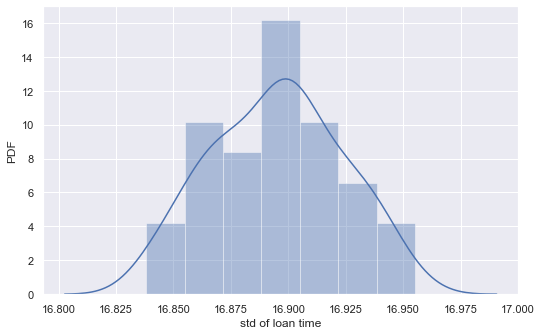

In [172]:
# Generate 100 bootstrap replicates of the *std*: bs_replicates
bs_replicates = draw_bs_reps(loan_time.dropna(), np.std, 100)

# histogram of the results
sns.distplot(bs_replicates)
plt.xlabel('std of loan time')
plt.ylabel('PDF')

# plot
plt.subplots_adjust(left=0, bottom=0, right=1.1, top=1, wspace=0, hspace=0)
plt.show()

As we can see, it is not normally distributed.

#### Do countries have influence regarding delays?

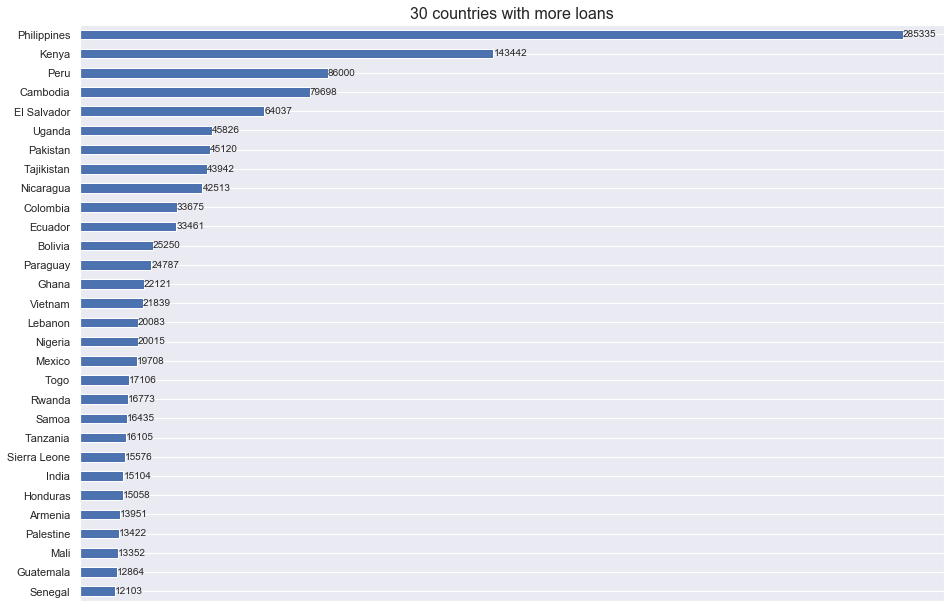

In [173]:
# Distribution of loans across countries

country_loans = df['country_name'].value_counts(ascending=True)[-30:]
country_loans_idx = df['country_name'].value_counts().index
pos = np.arange(len(country_loans))

# add the values to the side of each bar
for p, cidx, cl in zip(pos, country_loans_idx, country_loans):
    plt.annotate(cl, xy=(cl, p), va='center')

# formatting
plt.xticks([])
plt.title("30 countries with more loans", fontsize=16)
plt.subplots_adjust(left=0, bottom=-1, right=2, top=1, wspace=0, hspace=0.6)

country_loans.plot(kind='barh')
plt.show()

In [175]:
# 5 countries with more loan requests
print(df['country_name'].value_counts()[0:5])

# percentagewise
print(round(df['country_name'].value_counts()[0:5].sum()/df['country_name'].value_counts().sum()*100))

Philippines    285335
Kenya          143442
Peru            86000
Cambodia        79698
El Salvador     64037
Name: country_name, dtype: int64
46.0


50% of the loans go to 5 countries: Philippines, Kenya, Peru, Cambodia and El Salvador.

In [176]:
# 20 countries with more loan requests
print(df['country_name'].value_counts()[0:20])

# percentagewise
print(round(df['country_name'].value_counts()[0:20].sum()/df['country_name'].value_counts().sum()*100))
print(round(df['country_name'].value_counts()[0:30].sum()/df['country_name'].value_counts().sum()*100))

Philippines    285335
Kenya          143442
Peru            86000
Cambodia        79698
El Salvador     64037
Uganda          45826
Pakistan        45120
Tajikistan      43942
Nicaragua       42513
Colombia        33675
Ecuador         33461
Bolivia         25250
Paraguay        24787
Ghana           22121
Vietnam         21839
Lebanon         20083
Nigeria         20015
Mexico          19708
Togo            17106
Rwanda          16773
Name: country_name, dtype: int64
77.0
87.0


77% of the loans go to 20 countries. 87% to 30 countries.

How is the distribution of the time to fund for each of the main 5 countries?

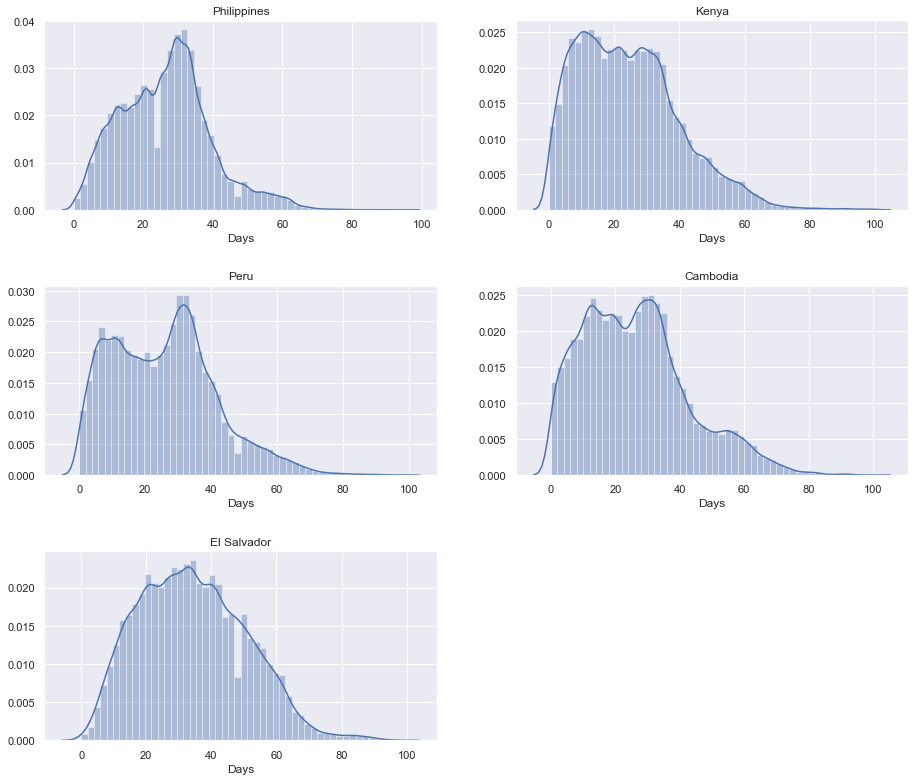

In [179]:
# Prepare dataset

# total differences
start_1 = df[df['posted_time'] < df['disburse_time']]
start_2 = df[df['posted_time'] > df['disburse_time']]

# select data
data_2 = pd.concat([start_1, start_2], axis=0)
data_2 = data_2.set_index('country_name')

# total differences
start_1_countries = data_2[data_2['posted_time'] < data_2['disburse_time']]
start_2_countries = data_2[data_2['posted_time'] > data_2['disburse_time']]

# loan_time_countries 1 & 2
loan_time_1_countries = start_1_countries['funded_time'] - start_1_countries['posted_time']
loan_time_2_countries = start_2_countries['funded_time'] - start_2_countries['disburse_time']

#concatenate
loan_time_countries = pd.concat([loan_time_1_countries.dt.days, loan_time_2_countries.dt.days], axis=0)

##############################

# countries time to fund
countries_5_list = ['Philippines', 'Kenya', 'Peru', 'Cambodia', 'El Salvador']
countries_5 = {}

for i in countries_5_list:
    countries_5[i] = loan_time_countries.loc[i]
    countries_5[i] = countries_5[i][countries_5[i].between(0, 100)]
    
# plots
for i, country in enumerate(countries_5_list):
    plt.subplot(3, 2, i + 1)
    sns.distplot(countries_5[country])
    plt.title(country)
    plt.xlabel("Days")

plt.subplots_adjust(left=0, bottom=-1.5, right=2, top=1, wspace=0.2, hspace=0.4)
plt.show()

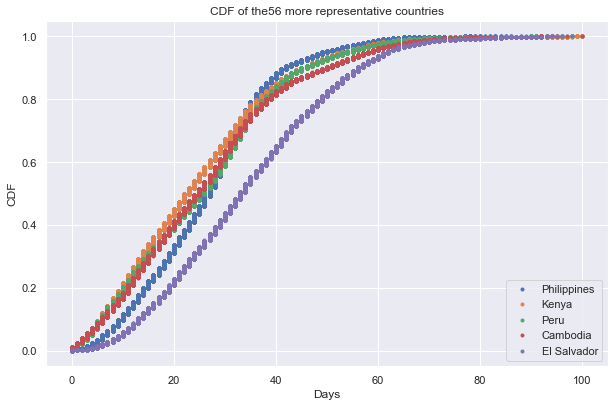

In [180]:
# ECDF's

for country in countries_5_list:
    x, y = ecdf(countries_5[country])
    plt.plot(x, y, marker='.', linestyle='none')

plt.legend(countries_5_list, loc='lower right')
plt.xlabel('Days')
plt.ylabel('CDF')
plt.title("CDF of the56 more representative countries")
plt.subplots_adjust(left=0, bottom=-0.2, right=1.3, top=1, wspace=0, hspace=0)
plt.show()

We clearly distinguish El Salvador from the other ones. It might be useful in further analysis. El Salvador takes 5% of the loans. The Philippines (20%) could also be a motive for further analysis.

#### When a loan is funded (96% of the data), how long does it take to get that funding, on average, in each country? Does the number of loans they have have any impact?

In [181]:
# redefine country_loans: include all
country_loans = df['country_name'].value_counts(ascending=True)

#concatenate
loan_time_amounts = pd.concat([start_1_countries.loan_amount, start_2_countries.loan_amount], axis=0)

# create list of countries and respective mean time of loan funding
countries_nr_loans = []
avg_time_fund = []
size_loans = []

for i in range(country_loans.count()):
    if country_loans.index[i] in loan_time_countries.index:
        countries_nr_loans.append(country_loans[i])
        avg_time_fund.append(round(loan_time_countries.loc[country_loans.index[i]].mean()))
        size_loans.append(round(loan_time_amounts.loc[country_loans.index[i]].mean())/10)

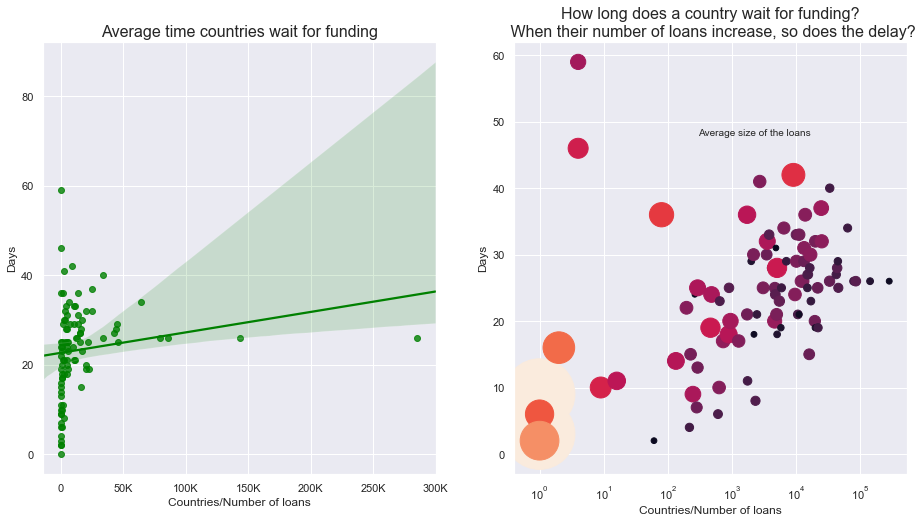

In [182]:
# create dataframe
loan_increase_time = pd.DataFrame({'countries_nr_loans': countries_nr_loans, 'avg_time_fund': avg_time_fund, 
                                   'size_loans': size_loans})

# scatter plot
plt.subplot(1, 2, 1)
# plt.scatter(countries_nr_loans, avg_time_fund)
sns.regplot(x='countries_nr_loans', y='avg_time_fund', data=loan_increase_time, color="green")
plt.title("Average time countries wait for funding", fontsize=16)
plt.xticks([0, 50000, 100000, 150000, 200000, 250000, 300000], ['0', '50K', '100K', '150K', '200K', '250K', '300K'])
plt.xlabel("Countries/Number of loans")
plt.ylabel("Days")

# scatter plot - log
plt.subplot(1, 2, 2)
plt.scatter(countries_nr_loans, avg_time_fund, s=size_loans, c=np.log10(size_loans))   
# sns.regplot(x='countries_nr_loans', y='avg_time_fund', data=loan_increase_time)
plt.text(300, 48, 'Average size of the loans')

# formatting
plt.title("How long does a country wait for funding?\n When their number of loans increase, so does the delay?", fontsize=16)
plt.xlabel("Countries/Number of loans")
plt.ylabel("Days")
plt.xscale('log') 

# plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0.2, hspace=0.4)
plt.show()

For countries with a few number of loans, the variation of average time to get the funding is significant. As soon as the number of loans start to increase, the average number of days to get the funding rapidly get close to 30, where most of them reside.

It seems to be that as the number of loans increases in a country, with all the remaining variables constant, so does the delay for funding a loan.

In [183]:
# pearson correlation coefficient formula
def pearson_r(data_1, data_2):
    return np.corrcoef(data_1, data_2)[0, 1]

# observed correlation coefficient
obs_corr = pearson_r(countries_nr_loans, avg_time_fund)

print("Correlation between the number of loans and time to fund:", obs_corr)

Correlation between the number of loans and time to fund: 0.15661234582192077


Is this positive correlation between the number of loans and time to fund significant? Let us test this assuming that there is 0 correlation between the 2 variables, leaving the time variable fixed while permuting 'countries_nr_loans'.

In [184]:
# 10000 permutations
perm_replicates = np.empty(10000)

for i in range(len(perm_replicates)):
    x_permuted = np.random.permutation(countries_nr_loans)
    perm_replicates[i] = pearson_r(x_permuted, avg_time_fund)

# p-value
p_value = np.sum(perm_replicates >= obs_corr) / len(perm_replicates)

print("p-value:", p_value)

p-value: 0.0602


Considering a significance level of 5%, we fail to reject the hypothesis that the 2 variables are independent of each other. Given this result, however, other factors such as the characteristics of each country loan could be more influential, but we will keep this in mind.

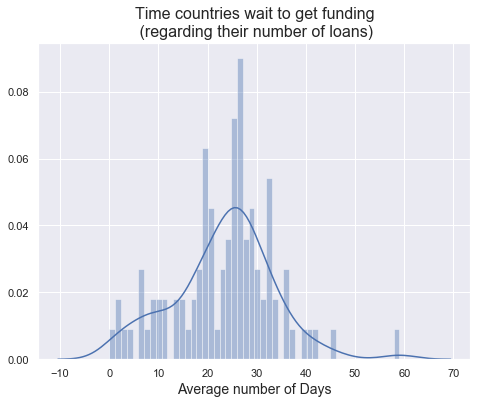

In [185]:
# histogram of the average number of days a country waits to get funding
sns.distplot(avg_time_fund, bins=50)

# formatting
plt.xlabel("Average number of Days", fontsize=14)
plt.title("Time countries wait to get funding\n (regarding their number of loans)", fontsize=16)

plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.show()

Here is the distribution of the time each country waits to get funding, which was suggested on the previous display. Here, the normal distribution seems to fit.

In [186]:
# D'Agostino's K-squared test
stat, p_value = normaltest(avg_time_fund)
print("D'Agostino's K-squared test: statistic=%.3f; p-value=%.3f" % (stat, p_value))

D'Agostino's K-squared test: statistic=2.865; p-value=0.239


We can now see which countries have more impact on the delay on average and maybe get hints why.

In [187]:
# adapt index
adapt_index = list(country_loans.index)
adapt_index.remove('Virgin Islands')

# identify country and set index
loan_increase_time['country'] = adapt_index
loan_increase_time = loan_increase_time.set_index('country')

# countries with an average time to fund loans > 30
more_time = loan_increase_time.sort_values('avg_time_fund', ascending=False)
more_time_30 = more_time[more_time['avg_time_fund'] >= 30]
more_time_30

,countries_nr_loans,avg_time_fund,size_loans
country,,,
Vanuatu,4,59.0,231.2
Guam,4,46.0,400.0
United States,9125,42.0,525.3
Myanmar (Burma),2724,41.0,154.2
Colombia,33675,40.0,70.1
Paraguay,24787,37.0,217.7
Armenia,13951,36.0,164.5
Burundi,1727,36.0,303.0
Puerto Rico,80,36.0,588.3


In [188]:
# number of countries with a delay >= 30
print("number of countries with a delay higher than 30 days:", more_time_30.avg_time_fund.count())

# percentage of loans
print("% of total loans:", round(more_time_30['countries_nr_loans'].sum() / loan_increase_time['countries_nr_loans'].sum() * 100))

number of countries with a delay higher than 30 days: 22
% of total loans: 19.0


Of these, USA, Colombia, Paraguay, Armenia, El Salvador, Lebanon, Bolivia, and Rwanda seem to have more impact.

#### When a loan is funded, do bigger loan amounts take more time to fund, on average?

In [190]:
# total differences
start_1 = df[df['posted_time'] < df['disburse_time']]
start_2 = df[df['posted_time'] > df['disburse_time']]

# select data
data_3 = pd.concat([start_1, start_2], axis=0)
data_3 = data_3.set_index('loan_amount')
data_3['loan_amount'] = data_3.index

# total differences (only considering the ones which were funded)
start_1_loan = data_3[(data_3['posted_time'] < data_3['disburse_time']) & (data_3['loan_amount'] <= data_3['funded_amount'])]
start_2_loan = data_3[(data_3['posted_time'] > data_3['disburse_time']) & (data_3['loan_amount'] <= data_3['funded_amount'])]

# loan_time_loans 1 & 2
loan_time_1_loan = start_1_loan['funded_time'] - start_1_loan['posted_time']
loan_time_2_loan = start_2_loan['funded_time'] - start_2_loan['disburse_time']

#concatenate
loan_time_loan_amounts = pd.concat([loan_time_1_loan.dt.days, loan_time_2_loan.dt.days], axis=0)


# create list of loan_amounts and mean time of funding
loan_amount_size = sorted(list(set(loan_time_loan_amounts.index)))
avg_time_loan = []

for i in loan_amount_size:
    avg_time_loan.append(round(loan_time_loan_amounts.loc[i].mean()))

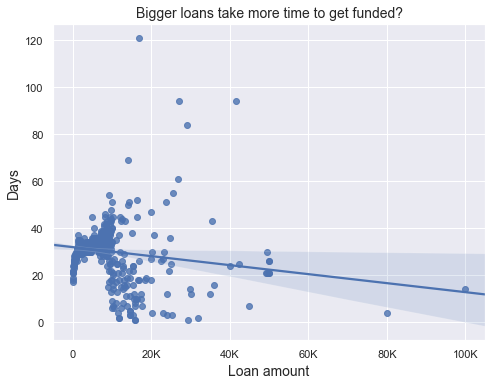

In [191]:
# create dataframe
loan_amount_time = pd.DataFrame({'loan_amount_size': loan_amount_size, 'avg_time_loan': avg_time_loan})

# scatter plot
sns.regplot(x='loan_amount_size', y='avg_time_loan', data=loan_amount_time)

# formatting
plt.title("Bigger loans take more time to get funded?", fontsize=14)
plt.xticks([0, 20000, 40000, 60000, 80000, 100000], ['0', '20K', '40K','60K', '80K', '100K'])
plt.xlabel("Loan amount", fontsize=14)
plt.ylabel("Days", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.show()

In [192]:
# observed correlation coefficient
obs_corr = pearson_r(loan_amount_size, avg_time_loan)

print("Correlation between loan amount and time to fund:", obs_corr)

Correlation between loan amount and time to fund: -0.16645602926720754


In [193]:
# 10000 permutations
perm_replicates = np.empty(10000)

for i in range(len(perm_replicates)):
    x_permuted = np.random.permutation(loan_amount_size)
    perm_replicates[i] = pearson_r(x_permuted, avg_time_loan)

# p-value
p_value = np.sum(perm_replicates <= obs_corr) / len(perm_replicates)

print("p-value:", p_value)

p-value: 0.0001


In general, there is a significant negative correlation between the size of the loan and the time it takes to get funded, when considering the average time each loan size takes to get funded. We must consider the results by the number of loans for each size, though.

#### Does the sector of the loan influences the time of funding?     

Distribution of loans among sectors

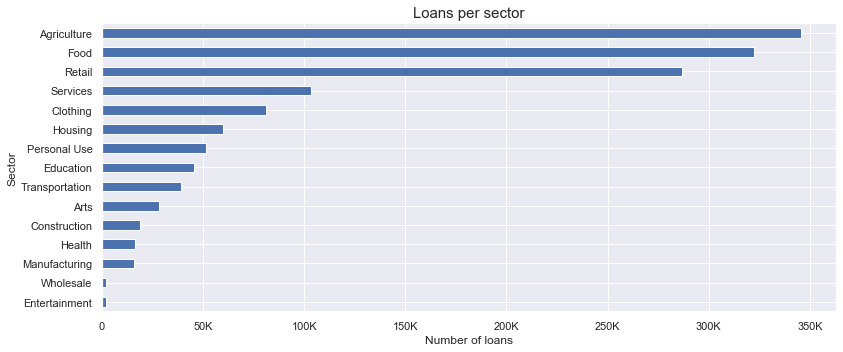

In [194]:
# quantity of loans each sector has
df['sector_name'].value_counts(ascending=True).plot(kind='barh')

# formatting
plt.title("Loans per sector", fontsize=15)
plt.xlabel("Number of loans")
plt.ylabel("Sector")
plt.xticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000], 
           ["0", "50K", "100K", "150K", "200K", "250K", "300K", "350K"])
plt.subplots_adjust(left=0, bottom=0, right=1.7, top=1, wspace=0, hspace=0.6)
plt.show()

In [196]:
# percentage of loans for the 5 main sectors
print(round(df['sector_name'].value_counts()[:5]/df['sector_name'].value_counts().sum()*100))

Agriculture    24.0
Food           23.0
Retail         20.0
Services        7.0
Clothing        6.0
Name: sector_name, dtype: float64


In [199]:
# percentage of loans for the 5 main sectors
print(round(df['sector_name'].value_counts()[:5].sum()/df['sector_name'].value_counts().sum()*100))

80.0


#### What is the relationship between the number of lenders and the time it takes to get funding?

In [202]:
# total differences
start_1 = df[df['posted_time'] < df['disburse_time']]
start_2 = df[df['posted_time'] > df['disburse_time']]

# select data
data_4 = pd.concat([start_1, start_2], axis=0)
data_4 = data_4.set_index('num_lenders_total')
data_4['num_lenders_total'] = data_4.index

# total differences 
start_1_numlend = data_4[(data_4['posted_time'] < data_4['disburse_time']) & (data_4['loan_amount'] <= data_4['funded_amount'])]
start_2_numlend = data_4[(data_4['posted_time'] > data_4['disburse_time']) & (data_4['loan_amount'] <= data_4['funded_amount'])]

# loan_time_numlend 1 & 2
loan_time_1_numlend = start_1_numlend['funded_time'] - start_1_numlend['posted_time']
loan_time_2_numlend = start_2_numlend['funded_time'] - start_2_numlend['disburse_time']

#concatenate
loan_time_numlend = pd.concat([loan_time_1_numlend.dt.days, loan_time_2_numlend.dt.days], axis=0)

# create list of loan_numlend and mean time of funding
loan_numlend = sorted(list(set(loan_time_numlend.index)))
avg_time_numlend = []

for i in loan_numlend:
    avg_time_numlend.append(round(loan_time_numlend.loc[i].mean()))

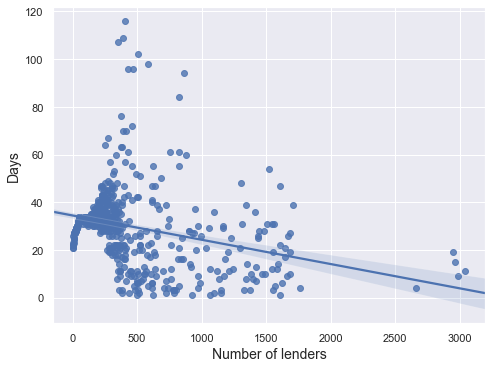

In [203]:
# create dataframe
loan_numlend_time = pd.DataFrame({'loan_numlend': loan_numlend, 'avg_time_numlend': avg_time_numlend})

# scatter plot
sns.regplot(x='loan_numlend', y='avg_time_numlend', data=loan_numlend_time)

# formatting
# plt.title("Less time to fund when more lenders come in", fontsize=16)
plt.xlabel("Number of lenders", fontsize=14)
plt.ylabel("Days", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.show()

Globally, as the number of lenders increased, the average number of days to fund a loan decreased. However, we should also look at what percentage of the total loans each dot (number of lenders) have.

Looking at the relationship between the number of loans per number of lenders.

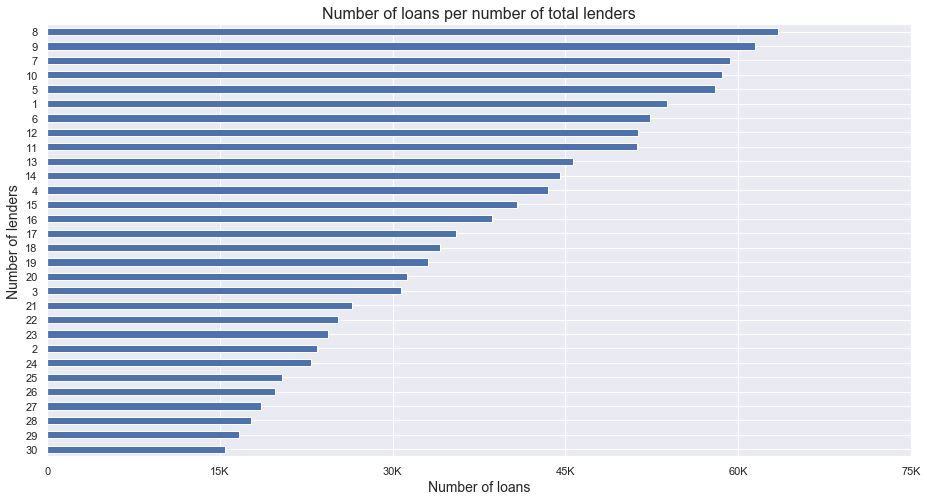

In [204]:
# number of loans per total number of lenders
df['num_lenders_total'].value_counts(ascending=True).tail(30).plot(kind='barh')

# formatting
plt.title("Number of loans per number of total lenders", fontsize=16)
plt.xlabel("Number of loans", fontsize=14)
plt.ylabel("Number of lenders", fontsize=14)
plt.xticks([0, 15000, 30000, 45000, 60000, 75000], ["0", "15K", "30K", "45K", "60K", "75K"])
plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0, hspace=0)
plt.show()

In [207]:
# percentage of total loans that the 60 highest number of loans per number of lenders
df['num_lenders_total'].value_counts(ascending=True).tail(60).sum()/len(df['num_lenders_total'])*100

93.80166046330055

#### Does repayment interval affect delay?

In [210]:
# number of loans per repayment interval
df['repayment_interval'].value_counts()

monthly      777963
irregular    529444
bullet       111093
weekly          622
Name: repayment_interval, dtype: int64

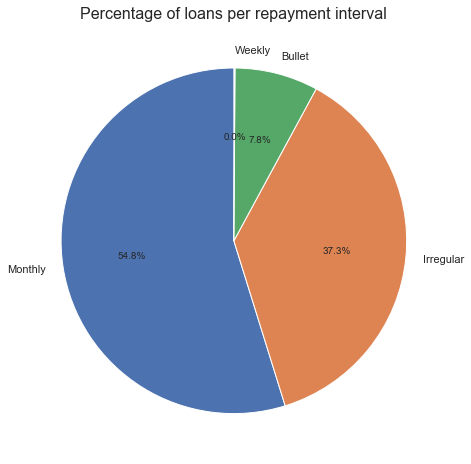

In [211]:
# define sizes
size_monthly = round(df['repayment_interval'].value_counts()[0]/df['repayment_interval'].value_counts().sum(), 3)
size_irregular = round(df['repayment_interval'].value_counts()[1]/df['repayment_interval'].value_counts().sum(), 3)
size_bullet = round(df['repayment_interval'].value_counts()[2]/df['repayment_interval'].value_counts().sum(), 3)
size_weekly = round(df['repayment_interval'].value_counts()[3]/df['repayment_interval'].value_counts().sum(), 3)

# formatting
labels = ["Monthly", "Irregular", "Bullet", "Weekly"]
sizes = [size_monthly, size_irregular, size_bullet, size_weekly]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Percentage of loans per repayment interval", fontsize=16)
plt.ylabel("")

plt.subplots_adjust(left=0, bottom=-0.5, right=1, top=1, wspace=0, hspace=0)
plt.show()

In [213]:
#total differences
start_1 = data[data['posted_time'] < data['disburse_time']]
start_2 = data[data['posted_time'] > data['disburse_time']]

# select data
data_5 = pd.concat([start_1, start_2], axis=0)
data_5 = data_5.set_index('repayment_interval')
data_5['repayment_interval'] = data_5.index

# total differences 
start_1_repay = data_5[data_5['posted_time'] < data_5['disburse_time']]
start_2_repay = data_5[data_5['posted_time'] > data_5['disburse_time']]

# repay_time_loans 1 & 2
repay_time_1_loan = start_1_repay['funded_time'] - start_1_repay['posted_time']
repay_time_2_loan = start_2_repay['funded_time'] - start_2_repay['disburse_time']

#concatenate
repay_time = pd.concat([repay_time_1_loan.dt.days, repay_time_2_loan.dt.days], axis=0)

# create list of repayment intervals, mean time of funding, and relative amount of loans
repay_intervals = list(set(repay_time.index))
avg_time_repay = []

for i in repay_intervals:
        avg_time_repay.append(round(repay_time.loc[i].mean()))

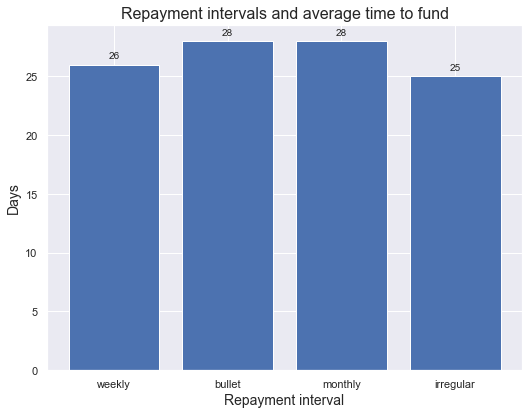

In [214]:
# repayment interval average time to fund
plt.bar(repay_intervals, avg_time_repay)

# formatting
plt.title("Repayment intervals and average time to fund", fontsize=16)
plt.xlabel("Repayment interval", fontsize=14)
plt.ylabel("Days", fontsize=14)

for x, y in zip(repay_intervals, avg_time_repay):
    plt.annotate("%i" % y, (x, y + 0.5), ha='center')

plt.subplots_adjust(left=0, bottom=-0.2, right=1.1, top=1, wspace=0, hspace=0)
plt.show()

#### Initial Feature Selection & Extraction:

### Selection:

## Modeling    

We will select only certain columns of interest, and exclude all the rows where a computation of the real time of delay was not possible. These don't affect the previous EDA made.

We will not consider the following variables:

['loan_id', 'funded_amount', 'status', 'activity_name', 'loan_use', 'country_code', 'town_name', 'posted_time', 'planned_expiration_time', 'disbursed_time', 'funded_time', 'borrower_genders']     

They are either not necessary, highly correlated with other variables or do not possess suficient quality data in order to be considered.

#### Building the new dataframe for modeling:

In [223]:
# total differences
start_1 = df[df['posted_time'] < df['disburse_time']]
start_2 = df[df['posted_time'] > df['disburse_time']]

# loan time 1 & 2
loan_time_1 = start_1['funded_time'] - start_1['posted_time']
loan_time_2 = start_2['funded_time'] - start_2['disburse_time']

#concatenate
real_time = pd.concat([loan_time_1, loan_time_2], axis=0)#dt.days

# new dataframe to deal with
new_df = pd.concat([start_1, start_2], axis=0)

# add the time to fund the loan
new_df['real_time'] = real_time

# order by date
new_df = new_df.sort_values('posted_time')

In [224]:
new_df.head()

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,partner_id,posted_time,planned_expiration_time,disburse_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval,real_time
1408669,308,700.0,700.0,funded,Catering,Food,House Repairing,KH,Cambodia,Phnom Penh City,...,9.0,2006-04-16 07:10:50+00:00,NaT,2006-05-03 19:40:18+00:00,2006-04-19 19:40:18+00:00,10.0,15,female,bullet,3 days 12:29:28
167485,311,1000.0,1000.0,funded,Vehicle Repairs,Services,Buying material and motorbike spare parts.,KH,Cambodia,Phnom Penh City,...,9.0,2006-04-16 07:10:50+00:00,NaT,2006-05-05 01:18:13+00:00,2006-04-21 01:18:13+00:00,12.0,15,male,bullet,4 days 18:07:23
129870,312,1600.0,1600.0,funded,Health,Health,House enlargement and furniture workshop opening,KH,Cambodia,Phnom Penh City,...,9.0,2006-04-16 07:10:50+00:00,NaT,2006-05-05 03:33:37+00:00,2006-04-21 03:33:37+00:00,18.0,18,female,bullet,4 days 20:22:47
102295,313,600.0,600.0,funded,Dairy,Agriculture,She would like to buy another dairy cow and in...,KE,Kenya,Makongeni,...,6.0,2006-04-17 22:05:12+00:00,NaT,2006-05-03 19:40:18+00:00,2006-04-19 19:40:18+00:00,15.0,6,female,monthly,1 days 21:35:06
851920,314,450.0,450.0,funded,Construction,Construction,Purchase of building supplies,UG,Uganda,Kampala,...,8.0,2006-04-17 22:05:37+00:00,NaT,2006-05-07 22:35:01+00:00,2006-04-23 22:35:01+00:00,9.0,10,female,irregular,6 days 00:29:24


#### Does lender term influence delay?

In [225]:
new_df[new_df.lender_term.isna()].shape

(23, 22)

Since there are 23 missing values in the lender_term column, let us opt to disconsider them.

In [226]:
# index values
lender_term_delete = new_df[new_df.lender_term.isna()].index

# remove rows
new_df = new_df.drop(lender_term_delete)

# new shape
new_df.shape

(1416557, 22)

Let us now look at the relationship between the lender term length and its average delay

In [227]:
# create array of unique lender terms and compute their mean delay
set_lender_terms = new_df.lender_term.unique()
avg_time_lender_term = []

for i in set_lender_terms:
    avg_time_lender_term.append(new_df[new_df['lender_term'] == i].real_time.dt.days.mean())

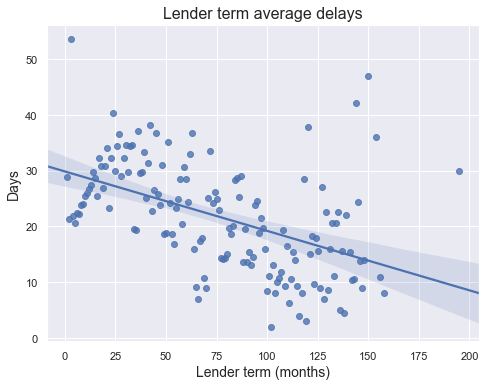

In [228]:
# create dataframe
time_lender_term = pd.DataFrame({'lender_term_i': set_lender_terms, 'avg_time_lender_term': avg_time_lender_term})

# scatter plot
sns.regplot(x='lender_term_i', y='avg_time_lender_term', data=time_lender_term)

# formatting
plt.title("Lender term average delays", fontsize=16)
plt.xlabel("Lender term (months)", fontsize=14)
plt.ylabel("Days", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.show()

In [229]:
# correlation
print("Correlation between lender term (months) and delay: {}".format(pearson_r(set_lender_terms, avg_time_lender_term)))

Correlation between lender term (months) and delay: -0.4954661735046611


As expected, the longer the lender term, the stronger the possibility that there is a smaller delay, on average.

#### how does the delay behaves over time?

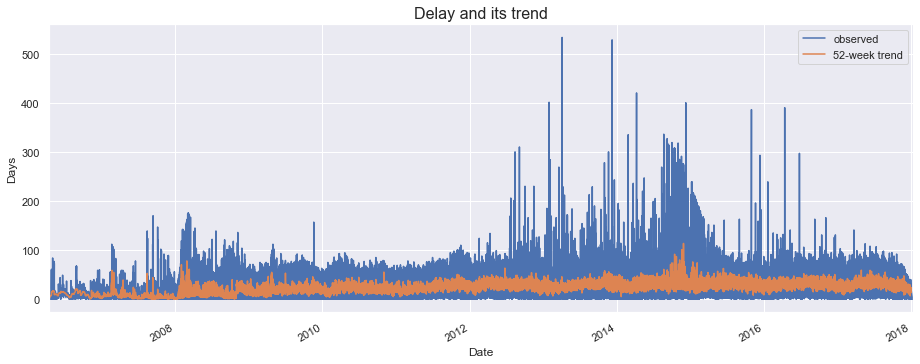

In [231]:
# delays dataframe
delays = pd.DataFrame({'real_time': new_df['real_time'].dt.days, 'time': new_df['posted_time']}).dropna()
delays.set_index('time', inplace=True)

# decomposition
decomposition = sm.tsa.seasonal_decompose(delays['real_time'], freq=52)

decomposition.observed.plot()
decomposition.trend.plot()

plt.title("")
plt.legend(['observed', '52-week trend'], loc='best')

plt.xlabel("Date")
plt.ylabel("Days")
plt.title("Delay and its trend", fontsize=16)
plt.subplots_adjust(left=0, bottom=0, right=2, top=1, wspace=0, hspace=0)
plt.show()

As we can see, there is a tendency to increase the fund delay over time.

## Feature Selection and Extraction

We will select only certain columns of interest, and exclude all the rows where a computation of the real time of delay was not possible. These don't affect the previous EDA made.

We will not consider the following variables:

['loan_id', 'funded_amount', 'status', 'activity_name', 'loan_use', 'country_code', 'town_name', 'posted_time', 'planned_expiration_time', 'disbursed_time', 'funded_time', 'borrower_genders']
They are either not necessary, highly correlated with other variables or do not possess suficient quality data in order to be considered.

In [233]:
# rows excluded
print("Number of real_time missing values excluded: {}".format(new_df[new_df.real_time.isna()].count().posted_time))

Number of real_time missing values excluded: 61732


In [234]:
# excluding them
missing_real_time = new_df[new_df.real_time.isna()].index

new_df = new_df.drop(missing_real_time)

# new shape
new_df.shape

(1354825, 22)

In [235]:
# rearrange new_df with only the columns of interest
col_interest = ['real_time', 'loan_amount', 'sector_name', 'country_name', 'currency_policy',
               'currency', 'partner_id', 'lender_term', 'repayment_interval', 'num_lenders_total']

new_df = new_df[col_interest]

# new shape
new_df.shape

(1354825, 10)

In [236]:
# info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1354825 entries, 1408669 to 780093
Data columns (total 10 columns):
real_time             1354825 non-null timedelta64[ns]
loan_amount           1354825 non-null float64
sector_name           1354825 non-null object
country_name          1354825 non-null object
currency_policy       1354825 non-null object
currency              1354825 non-null object
partner_id            1340846 non-null float64
lender_term           1354825 non-null float64
repayment_interval    1354825 non-null object
num_lenders_total     1354825 non-null int64
dtypes: float64(3), int64(1), object(5), timedelta64[ns](1)
memory usage: 113.7+ MB


We have missing data on the partner_id column, which represents individuals, that is, not a Kiva partner. Therefore, I will replace the missing values with 1.

In [237]:
# partner_id values
new_df['partner_id'].sort_values().unique()

array([  3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  13.,  15.,
        16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,
        27.,  30.,  31.,  32.,  33.,  34.,  36.,  37.,  40.,  41.,  42.,
        43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
        54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,
        65.,  66.,  67.,  70.,  71.,  72.,  73.,  74.,  76.,  77.,  78.,
        79.,  80.,  81.,  82.,  84.,  85.,  87.,  88.,  90.,  91.,  92.,
        93.,  96.,  97.,  98.,  99., 100., 101., 102., 104., 105., 106.,
       107., 108., 109., 110., 111., 112., 113., 115., 116., 117., 118.,
       119., 120., 121., 122., 123., 124., 125., 126., 127., 128., 129.,
       130., 131., 132., 133., 135., 136., 137., 138., 139., 140., 141.,
       142., 143., 144., 145., 146., 147., 148., 149., 150., 151., 152.,
       153., 154., 155., 156., 157., 158., 159., 160., 161., 162., 163.,
       164., 165., 166., 167., 168., 169., 170., 17

In [238]:
# replace NaN's with 1 (individuals)
new_df.partner_id.fillna(1, inplace=True)

In [239]:
# new info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1354825 entries, 1408669 to 780093
Data columns (total 10 columns):
real_time             1354825 non-null timedelta64[ns]
loan_amount           1354825 non-null float64
sector_name           1354825 non-null object
country_name          1354825 non-null object
currency_policy       1354825 non-null object
currency              1354825 non-null object
partner_id            1354825 non-null float64
lender_term           1354825 non-null float64
repayment_interval    1354825 non-null object
num_lenders_total     1354825 non-null int64
dtypes: float64(3), int64(1), object(5), timedelta64[ns](1)
memory usage: 113.7+ MB


In [240]:
# reset index
new_df_2 = new_df.copy()
new_df_2 = new_df_2.reset_index(drop=True)

# changing real_time variable to numeric 
new_df_2['real_time'] = new_df_2['real_time'].dt.days

# changing dtype of partner_id
new_df_2['partner_id'] = new_df_2['partner_id'].astype('category')

# head
new_df_2.head()

,real_time,loan_amount,sector_name,country_name,currency_policy,currency,partner_id,lender_term,repayment_interval,num_lenders_total
0,3,700.0,Food,Cambodia,not shared,USD,9.0,10.0,bullet,15
1,4,1000.0,Services,Cambodia,not shared,USD,9.0,12.0,bullet,15
2,4,1600.0,Health,Cambodia,not shared,USD,9.0,18.0,bullet,18
3,1,600.0,Agriculture,Kenya,not shared,USD,6.0,15.0,monthly,6
4,6,450.0,Construction,Uganda,not shared,USD,8.0,9.0,irregular,10


In [241]:
# final data frame
final_df = pd.get_dummies(new_df_2)

# head
final_df.head()

,real_time,loan_amount,lender_term,num_lenders_total,sector_name_Agriculture,sector_name_Arts,sector_name_Clothing,sector_name_Construction,sector_name_Education,sector_name_Entertainment,...,partner_id_551.0,partner_id_552.0,partner_id_553.0,partner_id_555.0,partner_id_556.0,partner_id_557.0,repayment_interval_bullet,repayment_interval_irregular,repayment_interval_monthly,repayment_interval_weekly
0,3,700.0,10.0,15,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,4,1000.0,12.0,15,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,4,1600.0,18.0,18,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,600.0,15.0,6,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,6,450.0,9.0,10,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


#### Countries: 

Let us keep only the main 50 countries, which represent 97% of the data and then turn the remaining countries into one variable named 'country_name_other'.

In [242]:
n = 50
print("Percentage of loans by the top {} countries: {}".format(n, new_df_2['country_name'].value_counts()[:n].sum()/
                                                                   new_df_2['country_name'].value_counts().sum()))

# keep only n countries with more loans 
countries_exclude = new_df_2['country_name'].value_counts()[n:].index

# create column 'country_name_other' for excluded countries
final_df['country_name_other'] = final_df[('country_name_' + countries_exclude)].sum(axis=1)

# exclude the individual countries
final_df = final_df.drop(('country_name_' + countries_exclude), axis=1)

Percentage of loans by the top 50 countries: 0.9697208126510803


#### Partners: 

Let us keep the main 100 partners (includes partner_id=1), which represent 85% of the data, and create 'partner_id_other' for any of the excluded partners.

In [243]:
n = 100
print("Percentage of loans by the top {} partners: {}".format(n, new_df_2['partner_id'].value_counts()[:n].sum()/
                                                                   new_df_2['partner_id'].value_counts().sum()))

# keep only n partner_id with more loans 
partners_exclude = new_df_2['partner_id'].value_counts()[n:].index

# create column 'partner_id_other' for excluded partners
final_df['partner_id_other'] = final_df[['partner_id_' + str(i) for i in partners_exclude]].sum(axis=1)

# drop partners_exclude
partners_exclude = ['partner_id_' + str(i) for i in partners_exclude]
final_df = final_df.drop(partners_exclude, axis=1)

Percentage of loans by the top 100 partners: 0.8529684645618438


#### Currency: 

Let us keep the main 25 currencies, which represent 90% of the data, and create a new feature named 'currency_other' for any of the excluded currencies.

In [244]:
n = 25
print("Percentage of loans by the top {} currencies: {}".format(n, new_df_2['currency'].value_counts()[:n].sum()/
                                                                   new_df_2['currency'].value_counts().sum()))

# keep only n currencies with more loans 
currencies_exclude = new_df_2['currency'].value_counts()[n:].index

# create column 'currency_other' for excluded currencies
final_df['currency_other'] = final_df[('currency_' + currencies_exclude)].sum(axis=1)

# drop those currencies
final_df = final_df.drop(('currency_' + currencies_exclude), axis=1)

Percentage of loans by the top 25 currencies: 0.9036384772941155


In [245]:
final_df.head()

,real_time,loan_amount,lender_term,num_lenders_total,sector_name_Agriculture,sector_name_Arts,sector_name_Clothing,sector_name_Construction,sector_name_Education,sector_name_Entertainment,...,partner_id_386.0,partner_id_428.0,partner_id_455.0,repayment_interval_bullet,repayment_interval_irregular,repayment_interval_monthly,repayment_interval_weekly,country_name_other,partner_id_other,currency_other
0,3,700.0,10.0,15,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,4,1000.0,12.0,15,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,4,1600.0,18.0,18,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,600.0,15.0,6,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,6,450.0,9.0,10,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0


##### Classification | "high" vs "low" delay     

We will treat the problem as a classification problem. The goal will be to classifiy a loan with either a "high" loan delay, that is, a loan that takes more than the median delay of all the loans in the data, or with a "low" loan delay, meaning that it will take less than the median, which in this case is equal to 26 days.

"high" loan delay: a loan that takes more than 26 days to fund: 1
"low" loan delay: a loan that takes less than 26 days to fund: 0     

#### Building a classification dataframe both for linear (scaling numeric variables) and non-linear cases:



### Linear Models

In [251]:
linear_df = final_df.copy()

linear_df.head()

,real_time,loan_amount,lender_term,num_lenders_total,sector_name_Agriculture,sector_name_Arts,sector_name_Clothing,sector_name_Construction,sector_name_Education,sector_name_Entertainment,...,partner_id_386.0,partner_id_428.0,partner_id_455.0,repayment_interval_bullet,repayment_interval_irregular,repayment_interval_monthly,repayment_interval_weekly,country_name_other,partner_id_other,currency_other
0,3,700.0,10.0,15,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,4,1000.0,12.0,15,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,4,1600.0,18.0,18,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,600.0,15.0,6,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,6,450.0,9.0,10,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0


In [253]:
# linear_df_class
linear_df_class = linear_df.copy()

# build the target variable
real_time_class = []

# median time delay
real_time_median = np.median(final_df['real_time'])  
print("Median time delay: {}".format(real_time_median))

# create class column
for i in linear_df_class['real_time']:
    if i > real_time_median:
        real_time_class.append(1)
    else:
        real_time_class.append(0)

# insert the new column and delete the float one
linear_df_class['real_time_class'] = real_time_class
linear_df_class = linear_df_class.drop('real_time', axis=1)

Median time delay: 26.0


In [254]:
%%time

# Scaling in scikit-learn
from sklearn.preprocessing import scale

# scale numerical features
linear_df_scaled = linear_df_class.drop(['loan_amount', 'lender_term'], axis=1)
scale_numeric = scale(linear_df_class[['loan_amount', 'lender_term']])
linear_df_scaled['loan_amount_scaled'] = scale_numeric[:, 0]
linear_df_scaled['lender_term'] = scale_numeric[:, 1]

# final df
linear_df_class = linear_df_scaled.copy()

# dataframe to deal in classification problem
linear_df_class.head()

Wall time: 4.29 s


,num_lenders_total,sector_name_Agriculture,sector_name_Arts,sector_name_Clothing,sector_name_Construction,sector_name_Education,sector_name_Entertainment,sector_name_Food,sector_name_Health,sector_name_Housing,...,repayment_interval_bullet,repayment_interval_irregular,repayment_interval_monthly,repayment_interval_weekly,country_name_other,partner_id_other,currency_other,real_time_class,loan_amount_scaled,lender_term
0,15,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,-0.096192,-0.376532
1,15,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0.191453,-0.108030
2,18,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0.766743,0.697473
3,6,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,-0.192074,0.294722
4,10,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,-0.335897,-0.510782


In [284]:
# Creating feature and target arrays
y_scaled = linear_df_class['real_time_class'].values
X_scaled = linear_df_class.drop('real_time_class', axis=1).values

from sklearn.model_selection import train_test_split
SEED = 10

# split the data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                                                                X_scaled, y_scaled, test_size=0.2, random_state=SEED)

### Non-Linear Models

In [256]:
# use
non_linear_df = final_df.copy()

In [257]:
# non-linear
non_linear_df

# build the target variable
real_time_class = []

# median time delay
real_time_median = np.median(final_df['real_time'])  
print("Median time delay: {}".format(real_time_median))

# create class column
for i in non_linear_df['real_time']:
    if i > real_time_median:
        real_time_class.append(1)
    else:
        real_time_class.append(0)

# insert the new column and delete the float one
non_linear_df['real_time_class'] = real_time_class
non_linear_df = non_linear_df.drop('real_time', axis=1)

# dataframe to deal in classification problem
non_linear_df.head()

Median time delay: 26.0


,loan_amount,lender_term,num_lenders_total,sector_name_Agriculture,sector_name_Arts,sector_name_Clothing,sector_name_Construction,sector_name_Education,sector_name_Entertainment,sector_name_Food,...,partner_id_428.0,partner_id_455.0,repayment_interval_bullet,repayment_interval_irregular,repayment_interval_monthly,repayment_interval_weekly,country_name_other,partner_id_other,currency_other,real_time_class
0,700.0,10.0,15,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,1000.0,12.0,15,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1600.0,18.0,18,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,600.0,15.0,6,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,450.0,9.0,10,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [264]:
%%time

# Creating feature and target arrays
y = non_linear_df['real_time_class'].values
X = non_linear_df.drop('real_time_class', axis=1).values

from sklearn.model_selection import train_test_split
SEED = 10

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

Wall time: 30.2 s


### Logistic Regression

In [265]:
%%time
from sklearn.linear_model import LogisticRegression

# Instatiate logreg
logreg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=SEED)

# Fit logreg to the training set
logreg.fit(X_train_scaled, y_train_scaled)

# predict
y_pred_scaled = logreg.predict(X_test_scaled)

C:\Users\sandhya.mukkamala\PycharmProjects\Conda\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Wall time: 8min 47s


#### Model performance

In [266]:
model = logreg
model_name = 'LogisticRegression'

In [267]:
%%time

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# score
print("Score:", model.score(X_test_scaled, y_test_scaled))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test_scaled, y_pred_scaled))

# Classification report
print("\nClassification report:\n", classification_report(y_test_scaled, y_pred_scaled))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob_scaled = model.predict_proba(X_test_scaled)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test_scaled, y_pred_prob_scaled)))

Score: 0.6668831767940508

Confusion matrix:
 [[87873 48656]
 [41607 92829]]

Classification report:
               precision    recall  f1-score   support

           0       0.68      0.64      0.66    136529
           1       0.66      0.69      0.67    134436

    accuracy                           0.67    270965
   macro avg       0.67      0.67      0.67    270965
weighted avg       0.67      0.67      0.67    270965


AUC: 0.7368133135505635
Wall time: 1.76 s


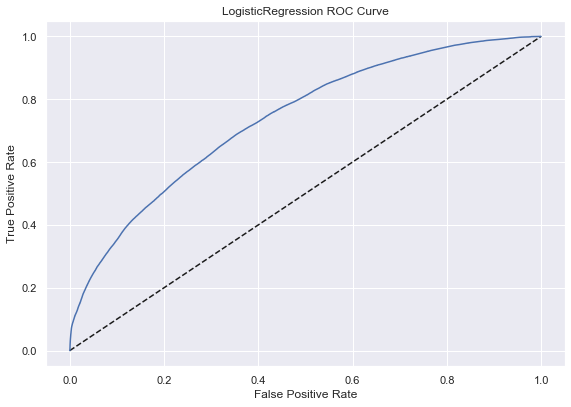

In [268]:
from sklearn.metrics import roc_curve

# Compute the predicted probabilities of the labels of the test set (X_test): y_pred_prob
y_pred_prob_scaled = model.predict_proba(X_test_scaled)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_scaled, y_pred_prob_scaled)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("{} ROC Curve".format(model_name))
plt.subplots_adjust(left=0, bottom=-0.2, right=1.2, top=1, wspace=0, hspace=0)
plt.show()

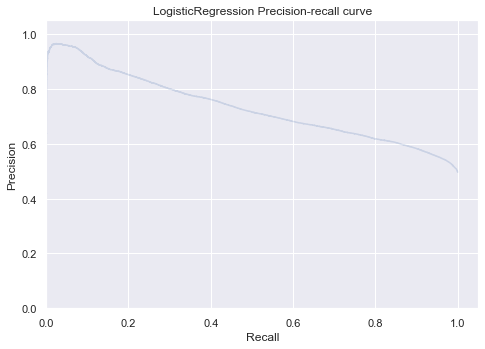

In [269]:
from sklearn.metrics import precision_recall_curve

# precision_recall_curve
y_score = model.decision_function(X_test_scaled)
precision, recall, _ = precision_recall_curve(y_test_scaled, y_score)
plt.step(recall, precision, color='b', alpha=0.2, where='post')

# formatting
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("{} Precision-recall curve".format(model_name))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.show()

### DecisionTreeClassifier

In [270]:
%%time
from sklearn.tree import DecisionTreeClassifier

# Instantiate dt
dt = DecisionTreeClassifier(random_state=SEED)

# Fit dt to the training set
dt.fit(X_train,y_train) 

# Predict test set labels
y_pred = dt.predict(X_test)

Wall time: 2min 43s


In [271]:
# Model performance
model = dt
model_name = 'DecisionTreeClassifier'

In [272]:
%%time
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.680353551196649

Confusion matrix:
 [[97087 39442]
 [47171 87265]]

Classification report:
               precision    recall  f1-score   support

           0       0.67      0.71      0.69    136529
           1       0.69      0.65      0.67    134436

    accuracy                           0.68    270965
   macro avg       0.68      0.68      0.68    270965
weighted avg       0.68      0.68      0.68    270965


AUC: 0.7012288907925024
Wall time: 2.47 s


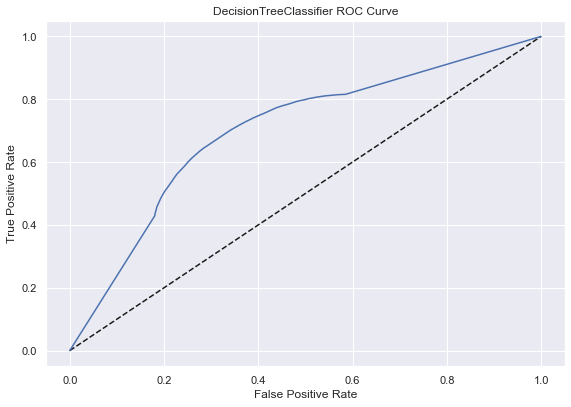

In [273]:
from sklearn.metrics import roc_curve

# Compute the predicted probabilities of the labels of the test set (X_test): y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("{} ROC Curve".format(model_name))
plt.subplots_adjust(left=0, bottom=-0.2, right=1.2, top=1, wspace=0, hspace=0)
plt.show()

### BaggingClassifier

In [274]:

%%time

# Import BaggingClassifier
from sklearn.ensemble import BaggingClassifier

# Instantiate bc
bc = BaggingClassifier(base_estimator=dt, random_state=SEED)

# Fit bc to the training set
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)

Wall time: 12min 12s


In [275]:
# Model performance
model = bc
model_name = 'BaggingClassifier'

In [276]:
%%time
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.6930009410809514

Confusion matrix:
 [[96906 39623]
 [43563 90873]]

Classification report:
               precision    recall  f1-score   support

           0       0.69      0.71      0.70    136529
           1       0.70      0.68      0.69    134436

    accuracy                           0.69    270965
   macro avg       0.69      0.69      0.69    270965
weighted avg       0.69      0.69      0.69    270965


AUC: 0.7612989910939915
Wall time: 42.2 s


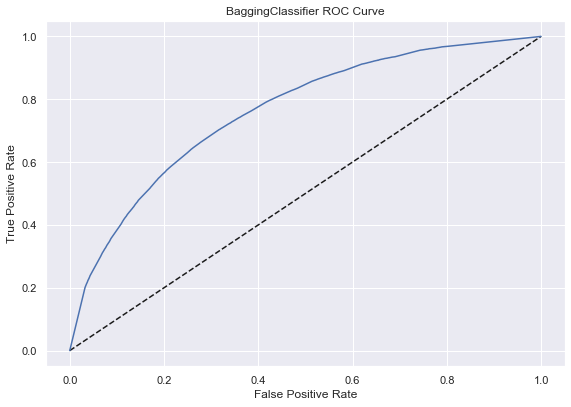

In [277]:
from sklearn.metrics import roc_curve

# Compute the predicted probabilities of the labels of the test set (X_test): y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("{} ROC Curve".format(model_name))
plt.subplots_adjust(left=0, bottom=-0.2, right=1.2, top=1, wspace=0, hspace=0)
plt.show()

### RandomForestClassifier

In [280]:
%%time
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Instantiate ada
rf = RandomForestClassifier(n_estimators=10, random_state=SEED)

# Fit ada to the training set
rf.fit(X_train, y_train)

# Predict test set labels
y_pred = rf.predict(X_test)

Wall time: 2min 44s


In [281]:
# Model performance
model = rf
model_name = 'RandomForestClassifier'

In [282]:
%%time
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.6944882180355396

Confusion matrix:
 [[97076 39453]
 [43330 91106]]

Classification report:
               precision    recall  f1-score   support

           0       0.69      0.71      0.70    136529
           1       0.70      0.68      0.69    134436

    accuracy                           0.69    270965
   macro avg       0.69      0.69      0.69    270965
weighted avg       0.69      0.69      0.69    270965


AUC: 0.7618833687969471
Wall time: 6.5 s


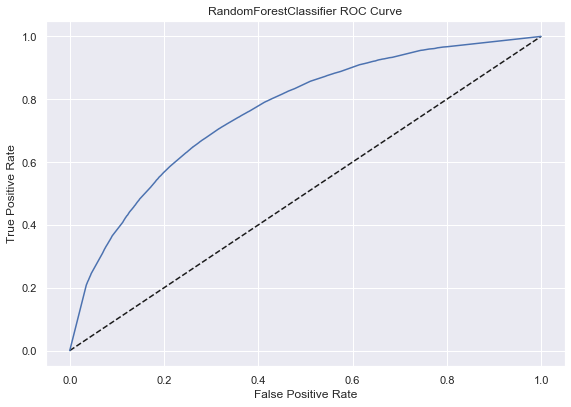

In [283]:
from sklearn.metrics import roc_curve

# Compute the predicted probabilities of the labels of the test set (X_test): y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("{} ROC Curve".format(model_name))
plt.subplots_adjust(left=0, bottom=-0.2, right=1.2, top=1, wspace=0, hspace=0)
plt.show()

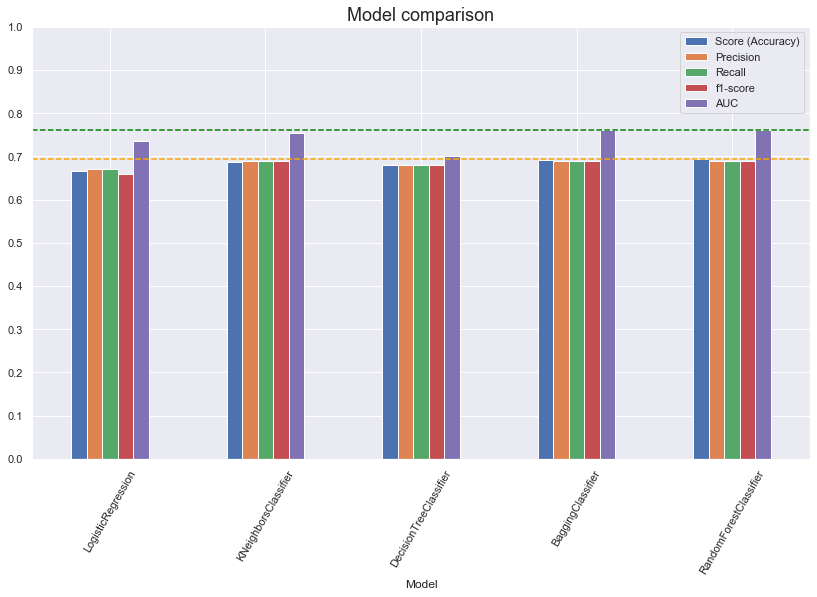

In [285]:
# individual results
r_logreg = np.array([0.666, 0.67, 0.67, 0.66, 0.737])
r_knn = np.array([0.687, 0.69, 0.69, 0.69, 0.754])
r_dt = np.array([0.680, 0.68, 0.68, 0.68, 0.701])
r_bc = np.array([0.693, 0.69, 0.69, 0.69, 0.761])
r_rf = np.array([0.694, 0.69, 0.69, 0.69, 0.762])

r_columns = ['Score (Accuracy)', 'Precision', 'Recall', 'f1-score', 'AUC']
r_index = ['LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'BaggingClassifier', 'RandomForestClassifier']

results = pd.DataFrame(np.row_stack([r_logreg, r_knn, r_dt, r_bc, r_rf]), 
                       index=r_index, columns=r_columns)

# plot
results.plot(kind='bar')

# formatting
plt.title("Model comparison", fontsize=18)
plt.xlabel("Model")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axhline(y=np.max(results['AUC']), c='green', linestyle='--')
plt.axhline(y=np.max(results[['Score (Accuracy)', 'Precision', 'Recall', 'f1-score']]).max(), c='orange', linestyle='--')
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(rotation=60)
plt.subplots_adjust(left=0, bottom=-0.5, right=1.8, top=1, wspace=0, hspace=0)
plt.show()

### Conclusion

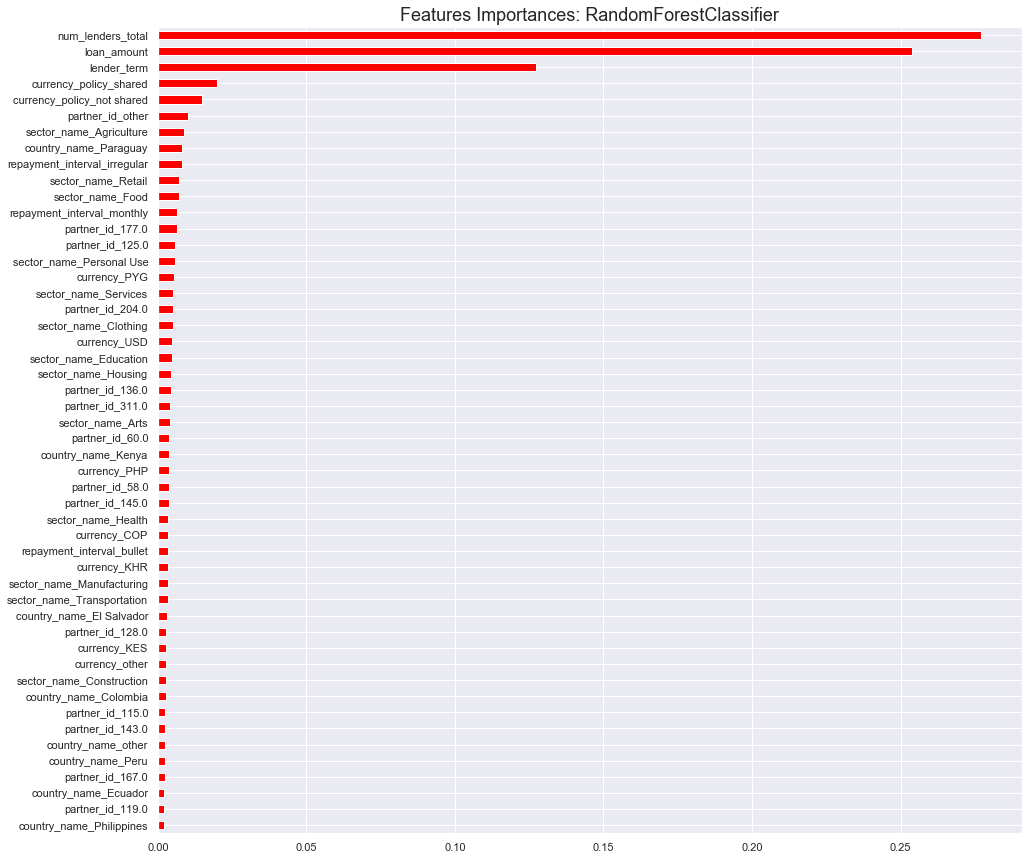

In [289]:
# Create a pd.Series of features importances
importances = pd.Series(data=model.feature_importances_, index=non_linear_df.drop('real_time_class', axis=1).columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.tail(50).plot(kind='barh', color='red')
plt.title('Features Importances: {}'.format(model_name), fontsize=18)
plt.subplots_adjust(left=0, bottom=-1.8, right=2, top=1, wspace=0, hspace=0)
plt.show()

We see that the amount of the loan ('loan_amount'), the total number of lenders ('num_lenders_total'), the lender term ('lender_term') and the currency policy ('currency_policy') are the most relevant features when predicting if a loan will be classified as one with a higher delay or not.